In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from pathlib import Path
from tqdm.auto import tqdm
from types import SimpleNamespace
import os
from PIL import Image
import csv

In [3]:
!ls -ltr /content/kitti_dataset

ls: cannot access '/content/kitti_dataset': No such file or directory


In [4]:
#!kaggle datasets download -d klemenko/kitti-dataset

# Create a directory to extract the dataset
#!mkdir -p /kaggle/kitti_dataset

# Extract the downloaded dataset
#!unzip -q klemenko/kitti-dataset.zip /kaggle/kitti_dataset

In [4]:
!ls -ltr /kaggle/input


total 0
drwxr-xr-x 6 nobody nogroup 0 Mar 27 06:40 kitti-dataset


In [5]:
!ls -ltr /kaggle/input/kitti-dataset

total 0
drwxr-xr-x 4 nobody nogroup 0 Mar 27 06:37 data_object_calib
drwxr-xr-x 4 nobody nogroup 0 Mar 27 06:38 data_object_image_2
drwxr-xr-x 4 nobody nogroup 0 Mar 27 06:39 data_object_image_3
drwxr-xr-x 3 nobody nogroup 0 Mar 27 06:40 data_object_label_2


In [ ]:
# Download the dataset to a specified directory
#!kaggle datasets download -d klemenko/kitti-dataset -p /kaggle/kitti_dataset

# Navigate to the directory where the dataset is downloaded
#%cd /kaggle/kitti_dataset

# Extract the downloaded dataset
#!unzip -q kitti-dataset.zip


In [6]:
!ls -ltr /kaggle/input/kitti-dataset

total 0
drwxr-xr-x 4 nobody nogroup 0 Mar 27 06:37 data_object_calib
drwxr-xr-x 4 nobody nogroup 0 Mar 27 06:38 data_object_image_2
drwxr-xr-x 4 nobody nogroup 0 Mar 27 06:39 data_object_image_3
drwxr-xr-x 3 nobody nogroup 0 Mar 27 06:40 data_object_label_2


In [7]:
def list_directory_structure(base_dir, depth=2):
    for root, dirs, files in os.walk(base_dir):
        level = root.replace(base_dir, '').count(os.sep)
        if level < depth:
            indent = ' ' * 4 * (level)
            print(f"{indent}{os.path.basename(root)}/")
            subindent = ' ' * 4 * (level + 1)
            for f in files:
                print(f"{subindent}{f}")

list_directory_structure('/kaggle/input/kitti-dataset')

kitti-dataset/
    data_object_calib/
    data_object_image_2/
    data_object_label_2/
    data_object_image_3/


In [8]:
!ls -ltr  /kaggle/input/kitti-dataset

total 0
drwxr-xr-x 4 nobody nogroup 0 Mar 27 06:37 data_object_calib
drwxr-xr-x 4 nobody nogroup 0 Mar 27 06:38 data_object_image_2
drwxr-xr-x 4 nobody nogroup 0 Mar 27 06:39 data_object_image_3
drwxr-xr-x 3 nobody nogroup 0 Mar 27 06:40 data_object_label_2


Visualizing images:


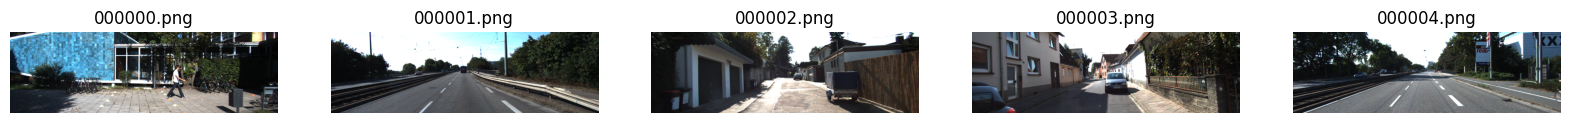

Analyzing image sizes:


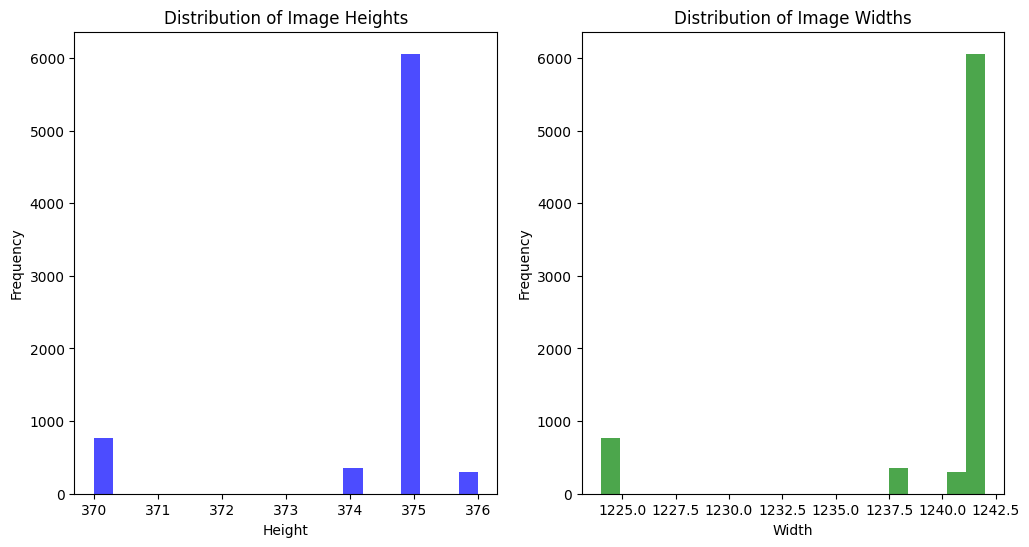

Counting classes in annotations:
Class counts: {'Pedestrian': 4487, 'Truck': 1094, 'Car': 28742, 'Cyclist': 1627, 'DontCare': 11295, 'Misc': 973, 'Van': 2914, 'Tram': 511, 'Person_sitting': 222}
Visualizing class distribution:


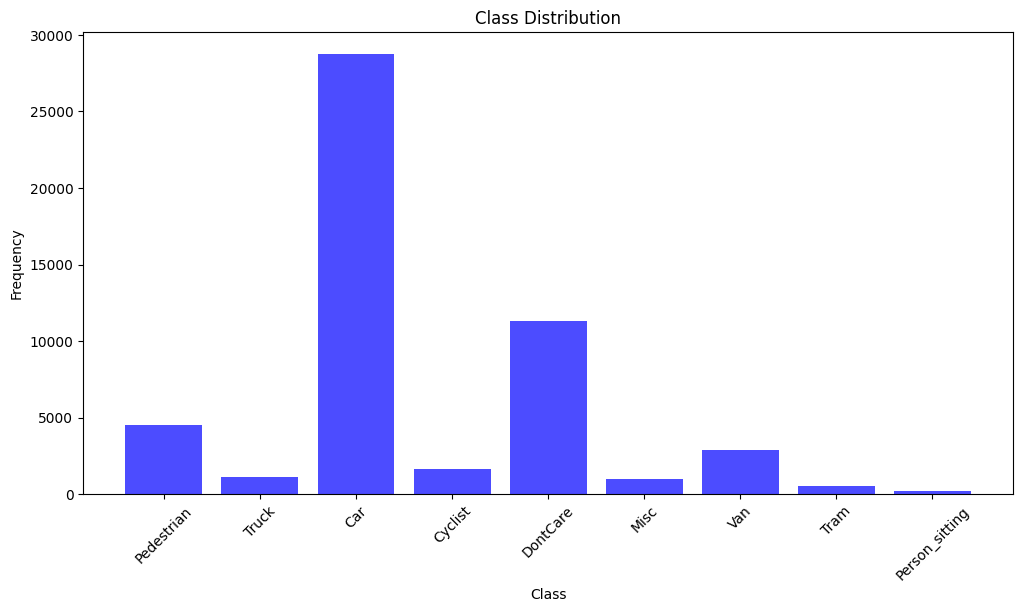

Displaying class statistics:
Total instances: 51865
Mean instances per class: 5762.777777777777
Standard deviation of instances per class: 8746.547150832057


In [10]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import numpy as np
from types import SimpleNamespace
from pathlib import Path

# Define the paths
meta = SimpleNamespace(base_dir = Path('/kaggle/input/kitti-dataset'))
meta.label_path = meta.base_dir / 'data_object_label_2' / 'training' / 'label_2'
meta.img_path = meta.base_dir / 'data_object_image_2' / 'training' / 'image_2'
meta.img_stereo_path = meta.base_dir / 'data_object_image_3' / 'training' / 'image_3'
meta.calib_path = meta.base_dir / 'data_object_calib' / 'training' / 'calib'
meta.ims = sorted(list(meta.img_path.glob('*')))
meta.labels = sorted(list(meta.label_path.glob('*')))
meta.stereo_ims = sorted(list(meta.img_stereo_path.glob('*')))
meta.label_colors = {
    'Car': (255,0,0),
    'Van': (255,255,0),
    'Truck': (255,255,255),
    'Pedestrian': (0,255,255),
    'Person_sitting': (0,255,255),
    'Cyclist': (0,128,255),
    'Tram': (128,0,0),
    'Misc': (0,255,255),
    'DontCare': (255,255,0)
}
meta.label_cols = [
    'label', 'truncated', 'occluded', 'alpha',
    'bbox_xmin', 'bbox_ymin', 'bbox_xmax',
    'bbox_ymax', 'dim_height', 'dim_width', 'dim_length',
    'loc_x', 'loc_y', 'loc_z', 'rotation_y', 'score'
]

meta.df = pd.DataFrame({
    'image': meta.ims,
    'stereo_image': meta.stereo_ims,
    'label': meta.labels
})

meta.im_width = 256
meta.im_height = 160

def get_label(p):
    data = pd.read_csv(
        p,
        sep=" ",
        names=meta.label_cols[:15],
        usecols=meta.label_cols[:15]
    )
    return data

# Visualize images to assess data quality
def visualize_images(image_paths, num_images=5):
    plt.figure(figsize=(20, 10))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Image {img_path} is not readable.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.show()

# Analyze image sizes and aspect ratios
def analyze_image_sizes(image_paths):
    image_shapes = [cv2.imread(str(img)).shape for img in image_paths if cv2.imread(str(img)) is not None]
    heights, widths = zip(*[(shape[0], shape[1]) for shape in image_shapes])

    # Plot distributions
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=20, color='blue', alpha=0.7)
    plt.title('Distribution of Image Heights')
    plt.xlabel('Height')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=20, color='green', alpha=0.7)
    plt.title('Distribution of Image Widths')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.show()

# Count the number of instances per class
def count_classes_from_labels(label_paths):
    class_counts = {}
    for label_file in label_paths:
        data = get_label(label_file)
        for label in data['label']:
            class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

# Visualize the class distribution
def visualize_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, counts, color='blue', alpha=0.7)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Display statistics such as mean and standard deviation for each class
def display_class_statistics(class_counts):
    total_instances = sum(class_counts.values())
    mean_instances = np.mean(list(class_counts.values()))
    std_instances = np.std(list(class_counts.values()))

    print(f"Total instances: {total_instances}")
    print(f"Mean instances per class: {mean_instances}")
    print(f"Standard deviation of instances per class: {std_instances}")

# Data Quality Assessment
print("Visualizing images:")
visualize_images(meta.ims)

print("Analyzing image sizes:")
analyze_image_sizes(meta.ims)

# Class Analysis
print("Counting classes in annotations:")
class_counts = count_classes_from_labels(meta.labels)
print("Class counts:", class_counts)

# Visualize class distribution
print("Visualizing class distribution:")
visualize_class_distribution(class_counts)

# Display class statistics
print("Displaying class statistics:")
display_class_statistics(class_counts)


In [ ]:
#get_label(meta.df['label'][55])

In [ ]:
#plt.imshow(open_image(meta.df['stereo_image'][123]))

In [ ]:
#!ls -ltr /kaggle/input/data_object_label_2/training/label_2

# ****Elimination of Variables

In [11]:
import pandas as pd
from pathlib import Path
from types import SimpleNamespace
import numpy as np

# Define paths
meta = SimpleNamespace(base_dir = Path('/kaggle/input/kitti-dataset'))
meta.label_path = meta.base_dir / 'data_object_label_2' / 'training' / 'label_2'
meta.label_cols = [
    'label', 'truncated', 'occluded', 'alpha',
    'bbox_xmin', 'bbox_ymin', 'bbox_xmax',
    'bbox_ymax', 'dim_height', 'dim_width', 'dim_length',
    'loc_x', 'loc_y', 'loc_z', 'rotation_y', 'score'
]
columns_to_keep = ['label', 'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']

# Function to eliminate unnecessary variables
def eliminate_variables(label_file):
    data = pd.read_csv(
        label_file,
        sep=" ",
        names=meta.label_cols[:15],
        usecols=meta.label_cols[:15]
    )
    return data[columns_to_keep]

# Process the entire dataset
def process_dataset(label_path):
    all_data = []
    for label_file in label_path.glob('*.txt'):
        filtered_data = eliminate_variables(label_file)
        all_data.append(filtered_data)
    return pd.concat(all_data, ignore_index=True)

# Example usage
processed_data = process_dataset(meta.label_path)
print(processed_data.head())


  label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
0   Car     572.30     185.01     621.87     225.02
1   Car     506.01     182.79     554.75     215.37
2   Car     354.98     183.52     401.03     207.84
3   Car       0.00     185.66     124.97     275.12
4   Van     597.32     165.04     621.59     197.95


# ****4.3.2 Transformation into Categorical Variables****

In [12]:
# Define mapping for labels to categorical values
label_mapping = {
    'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3, 
    'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Misc': 7, 'DontCare': 8
}

# Function to transform labels into categorical variables
def transform_to_categorical(data):
    data['label'] = data['label'].map(label_mapping)
    return data

# Example usage
transformed_data = transform_to_categorical(processed_data)
print(transformed_data.head())


   label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
0      0     572.30     185.01     621.87     225.02
1      0     506.01     182.79     554.75     215.37
2      0     354.98     183.52     401.03     207.84
3      0       0.00     185.66     124.97     275.12
4      1     597.32     165.04     621.59     197.95


# ****4.3.3 Identification of Missing Values

In [13]:
# Function to identify missing values
def identify_missing_values(data):
    missing_values = data.isnull().sum()
    return missing_values

# Example usage
missing_values = identify_missing_values(transformed_data)
print(missing_values)


label        0
bbox_xmin    0
bbox_ymin    0
bbox_xmax    0
bbox_ymax    0
dtype: int64


# ****4.3.4 Univariate Analysis


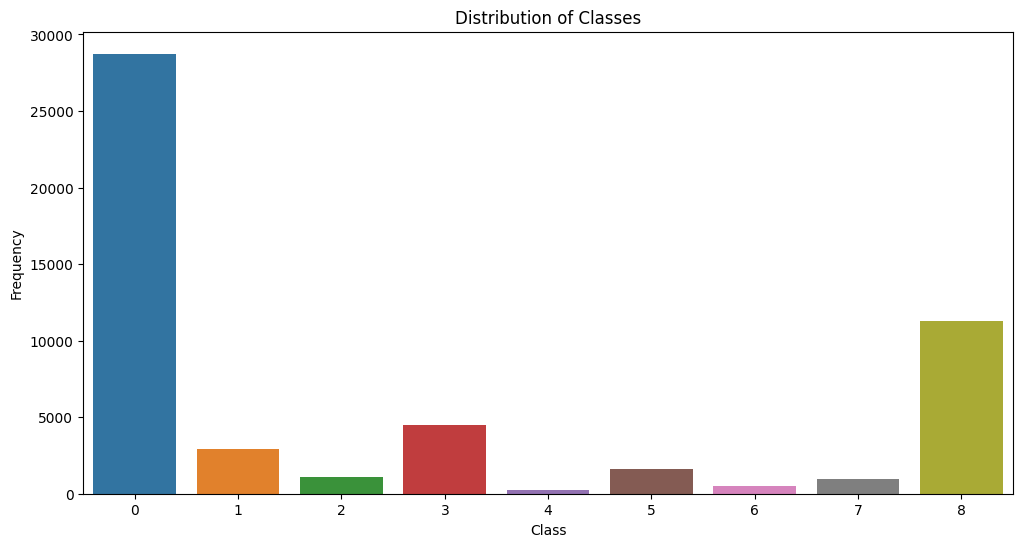

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to perform univariate analysis
def univariate_analysis(data):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='label', data=data)
    plt.title('Distribution of Classes')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

# Example usage
univariate_analysis(transformed_data)


# ****4.3.5 Treatment of Missing Values

In [15]:
# Function to treat missing values
def treat_missing_values(data):
    # Example: Fill missing values with the mean of the column
    data = data.fillna(data.mean())
    return data

# Example usage
treated_data = treat_missing_values(transformed_data)
print(treated_data.isnull().sum())  # Check if missing values are treated


label        0
bbox_xmin    0
bbox_ymin    0
bbox_xmax    0
bbox_ymax    0
dtype: int64


# ****4.3.6 Splitting of Original Dataset

In [16]:
from sklearn.model_selection import train_test_split

# Function to split the dataset
def split_dataset(data, test_size=0.2, val_size=0.1):
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=val_size/(1-test_size), random_state=42)
    return train_data, val_data, test_data

# Example usage
train_data, val_data, test_data = split_dataset(treated_data)
print("Train Data:", train_data.shape)
print("Validation Data:", val_data.shape)
print("Test Data:", test_data.shape)


Train Data: (36305, 5)
Validation Data: (5187, 5)
Test Data: (10373, 5)


# Exploratory Data Analysis (Bivariate Analysis)

## Chi-square Test

### **Step 1: Prepare the Dataset for the Chi-square Test**

In [17]:
# Create a new column 'position' based on bbox_xmin
def create_position_column(data):
    data['position'] = data['bbox_xmin'].apply(lambda x: 'left' if x < data['bbox_xmin'].median() else 'right')
    return data

# Example usage
transformed_data = create_position_column(transformed_data)
print(transformed_data.head())


   label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax position
0      0     572.30     185.01     621.87     225.02    right
1      0     506.01     182.79     554.75     215.37     left
2      0     354.98     183.52     401.03     207.84     left
3      0       0.00     185.66     124.97     275.12     left
4      1     597.32     165.04     621.59     197.95    right


In [18]:
import pandas as pd

# Function to prepare the dataset for the Chi-square test
def prepare_chi_square_data(data, column):
    # Creating a contingency table
    contingency_table = pd.crosstab(data['label'], data[column])
    return contingency_table

# Example usage
contingency_table = prepare_chi_square_data(transformed_data, 'position')
print(contingency_table)


position   left  right
label                 
0         15653  13089
1          1455   1459
2           384    710
3          1873   2614
4            93    129
5           575   1052
6           244    267
7           668    305
8          4987   6308


## Perform the Chi-square Test

In [19]:
from scipy.stats import chi2_contingency

# Function to perform the Chi-square test
def chi_square_test(contingency_table):
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p, dof, expected

# Example usage
chi2, p, dof, expected = chi_square_test(contingency_table)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)


Chi2: 884.8903162230265
P-value: 1.0253790132342183e-185
Degrees of Freedom: 8
Expected Frequencies:
[[14370.72291526 14371.27708474]
 [ 1456.97190784  1457.02809216]
 [  546.98945339   547.01054661]
 [ 2243.45674347  2243.54325653]
 [  110.99785983   111.00214017]
 [  813.48431505   813.51568495]
 [  255.49507375   255.50492625]
 [  486.49061988   486.50938012]
 [ 5647.39111154  5647.60888846]]


### Interpret the Results

In [20]:
# Function to interpret the results of the Chi-square test
def interpret_chi_square(p, alpha=0.05):
    if p < alpha:
        print(f"Since p-value {p} < alpha {alpha}, we reject the null hypothesis.")
        print("There is a significant association between the variables.")
    else:
        print(f"Since p-value {p} >= alpha {alpha}, we fail to reject the null hypothesis.")
        print("There is no significant association between the variables.")

# Example usage
interpret_chi_square(p)


Since p-value 1.0253790132342183e-185 < alpha 0.05, we reject the null hypothesis.
There is a significant association between the variables.


# Full Integration Example

Cell 1: Create a New Categorical Column for Testing****



In [21]:
# Create a new column 'position' based on bbox_xmin
def create_position_column(data):
    data['position'] = data['bbox_xmin'].apply(lambda x: 'left' if x < data['bbox_xmin'].median() else 'right')
    return data

# Example usage
transformed_data = create_position_column(transformed_data)
print(transformed_data.head())


   label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax position
0      0     572.30     185.01     621.87     225.02    right
1      0     506.01     182.79     554.75     215.37     left
2      0     354.98     183.52     401.03     207.84     left
3      0       0.00     185.66     124.97     275.12     left
4      1     597.32     165.04     621.59     197.95    right


# Prepare the Dataset for the Chi-square Test

In [22]:
import pandas as pd

# Assuming transformed_data is already created from previous steps
# Function to prepare the dataset for the Chi-square test
def prepare_chi_square_data(data, column):
    # Creating a contingency table
    contingency_table = pd.crosstab(data['label'], data[column])
    return contingency_table

# Example usage
contingency_table = prepare_chi_square_data(transformed_data, 'position')
print(contingency_table)


position   left  right
label                 
0         15653  13089
1          1455   1459
2           384    710
3          1873   2614
4            93    129
5           575   1052
6           244    267
7           668    305
8          4987   6308


# Perform the Chi-square Test

In [23]:
from scipy.stats import chi2_contingency

# Function to perform the Chi-square test
def chi_square_test(contingency_table):
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p, dof, expected

# Example usage
chi2, p, dof, expected = chi_square_test(contingency_table)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)


Chi2: 884.8903162230265
P-value: 1.0253790132342183e-185
Degrees of Freedom: 8
Expected Frequencies:
[[14370.72291526 14371.27708474]
 [ 1456.97190784  1457.02809216]
 [  546.98945339   547.01054661]
 [ 2243.45674347  2243.54325653]
 [  110.99785983   111.00214017]
 [  813.48431505   813.51568495]
 [  255.49507375   255.50492625]
 [  486.49061988   486.50938012]
 [ 5647.39111154  5647.60888846]]


# Interpret the Results

In [24]:
# Function to interpret the results of the Chi-square test
def interpret_chi_square(p, alpha=0.05):
    if p < alpha:
        print(f"Since p-value {p} < alpha {alpha}, we reject the null hypothesis.")
        print("There is a significant association between the variables.")
    else:
        print(f"Since p-value {p} >= alpha {alpha}, we fail to reject the null hypothesis.")
        print("There is no significant association between the variables.")

# Example usage
interpret_chi_square(p)


Since p-value 1.0253790132342183e-185 < alpha 0.05, we reject the null hypothesis.
There is a significant association between the variables.


### Correlation Analysis

### Step 1: Calculate Correlation Matrix

In [25]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = transformed_data[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].corr()
print(correlation_matrix)


           bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
bbox_xmin   1.000000  -0.257362   0.946288  -0.206396
bbox_ymin  -0.257362   1.000000  -0.280662   0.077147
bbox_xmax   0.946288  -0.280662   1.000000   0.024295
bbox_ymax  -0.206396   0.077147   0.024295   1.000000


### Step 2: Visualize Correlation Matrix

In [26]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = transformed_data[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].corr()
print(correlation_matrix)


           bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
bbox_xmin   1.000000  -0.257362   0.946288  -0.206396
bbox_ymin  -0.257362   1.000000  -0.280662   0.077147
bbox_xmax   0.946288  -0.280662   1.000000   0.024295
bbox_ymax  -0.206396   0.077147   0.024295   1.000000


## T-tests

### Step 1: Perform T-tests for All Pairs of Classes

In [27]:
from scipy.stats import ttest_ind
import itertools

# Function to perform T-test for all pairs of classes
def perform_all_t_tests(data, column):
    results = []
    unique_classes = data['label'].unique()
    class_pairs = list(itertools.combinations(unique_classes, 2))
    for label1, label2 in class_pairs:
        group1 = data[data['label'] == label1][column]
        group2 = data[data['label'] == label2][column]
        t_stat, p_val = ttest_ind(group1, group2)
        results.append((label1, label2, t_stat, p_val))
    return results

# Example usage
t_test_results = perform_all_t_tests(transformed_data, 'bbox_xmin')
for result in t_test_results:
    print(f"Labels: {result[0]} vs {result[1]}, T-statistic: {result[2]}, P-value: {result[3]}")

Labels: 0 vs 1, T-statistic: -8.03112925458136, P-value: 9.990195989713702e-16
Labels: 0 vs 8, T-statistic: -25.01710359501773, P-value: 4.517626164679011e-137
Labels: 0 vs 7, T-statistic: 1.8472704993492328, P-value: 0.06471788080072037
Labels: 0 vs 5, T-statistic: -21.645663144073488, P-value: 4.0257588946466487e-103
Labels: 0 vs 3, T-statistic: -25.81138066350597, P-value: 1.8014357520169427e-145
Labels: 0 vs 2, T-statistic: -5.235168187563108, P-value: 1.659499578466869e-07
Labels: 0 vs 6, T-statistic: -3.0997261202128614, P-value: 0.0019388348770360956
Labels: 0 vs 4, T-statistic: -7.744287187477933, P-value: 9.924829690256801e-15
Labels: 1 vs 8, T-statistic: -6.020438343769161, P-value: 1.7823083965291019e-09
Labels: 1 vs 7, T-statistic: 5.602665393039123, P-value: 2.2571609899988315e-08
Labels: 1 vs 5, T-statistic: -12.46543230357431, P-value: 4.3014265794894503e-35
Labels: 1 vs 3, T-statistic: -10.581183467491366, P-value: 5.58276261650788e-26
Labels: 1 vs 2, T-statistic: -0.10

## ANOVA (Analysis of Variance)

### Step 1: Perform ANOVA for All Classes

In [28]:
from scipy.stats import f_oneway

# Function to perform ANOVA
def perform_anova(data, column):
    unique_classes = data['label'].unique()
    groups = [data[data['label'] == label][column] for label in unique_classes]
    f_stat, p_val = f_oneway(*groups)
    return f_stat, p_val

# Example usage
f_stat, p_val = perform_anova(transformed_data, 'bbox_xmin')
print(f"F-statistic: {f_stat}, P-value: {p_val}")


F-statistic: 190.4832940678666, P-value: 4.97905e-319


## 4. Scatter Plots

### Step 1: Create Scatter Plots for All Pairs of Numerical Variables

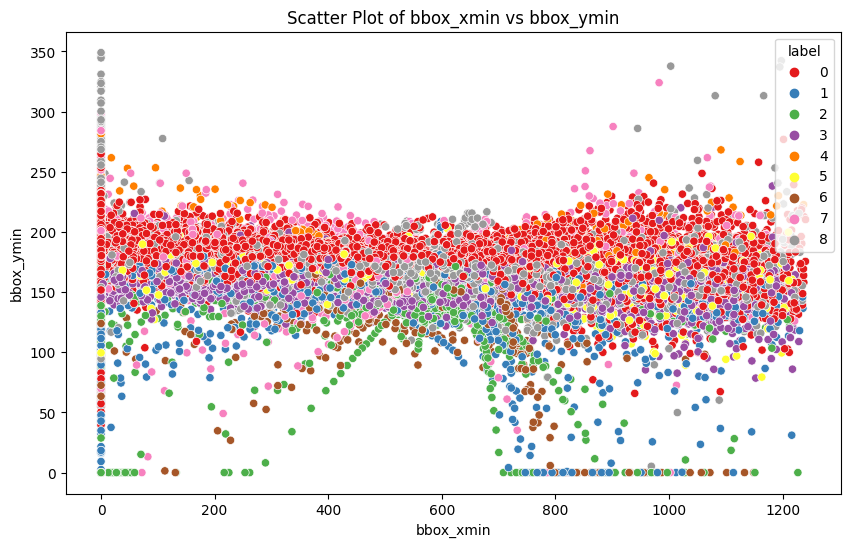

In [29]:
# Function to create scatter plot
def plot_scatter(data, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_col, y=y_col, hue='label', data=data, palette='Set1')
    plt.title(f'Scatter Plot of {x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Example usage
plot_scatter(transformed_data, 'bbox_xmin', 'bbox_ymin')


### 5. Box Plots

### Step 1: Create Box Plots for All Numerical Variables

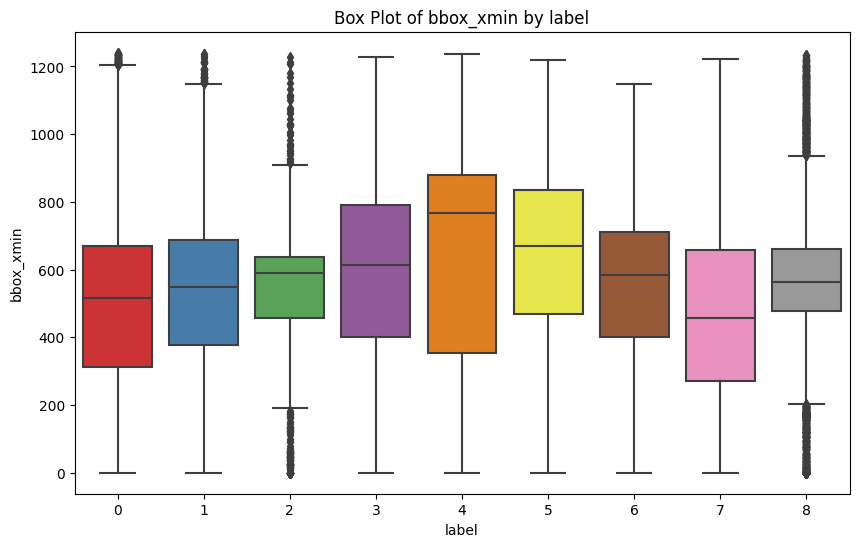

In [30]:
# Function to create box plot
def plot_box(data, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data, palette='Set1')
    plt.title(f'Box Plot of {y_col} by {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Example usage
plot_box(transformed_data, 'label', 'bbox_xmin')


## Full Example in a Notebook

### Cell 1: Correlation Analysis

           bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
bbox_xmin   1.000000  -0.257362   0.946288  -0.206396
bbox_ymin  -0.257362   1.000000  -0.280662   0.077147
bbox_xmax   0.946288  -0.280662   1.000000   0.024295
bbox_ymax  -0.206396   0.077147   0.024295   1.000000


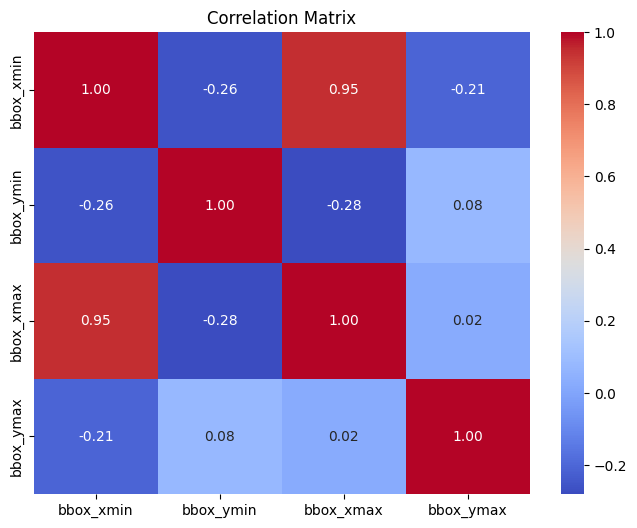

In [31]:
# Calculate the correlation matrix for numerical variables
correlation_matrix = transformed_data[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].corr()
print(correlation_matrix)

# Function to visualize the correlation matrix
def plot_correlation_matrix(correlation_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

# Example usage
plot_correlation_matrix(correlation_matrix)


### Cell 2: T-tests for All Pairs of Classes

In [32]:
from scipy.stats import ttest_ind
import itertools

# Function to perform T-test for all pairs of classes
def perform_all_t_tests(data, column):
    results = []
    unique_classes = data['label'].unique()
    class_pairs = list(itertools.combinations(unique_classes, 2))
    for label1, label2 in class_pairs:
        group1 = data[data['label'] == label1][column]
        group2 = data[data['label'] == label2][column]
        t_stat, p_val = ttest_ind(group1, group2)
        results.append((label1, label2, t_stat, p_val))
    return results

# Example usage
t_test_results = perform_all_t_tests(transformed_data, 'bbox_xmin')
for result in t_test_results:
    print(f"Labels: {result[0]} vs {result[1]}, T-statistic: {result[2]}, P-value: {result[3]}")


Labels: 0 vs 1, T-statistic: -8.03112925458136, P-value: 9.990195989713702e-16
Labels: 0 vs 8, T-statistic: -25.01710359501773, P-value: 4.517626164679011e-137
Labels: 0 vs 7, T-statistic: 1.8472704993492328, P-value: 0.06471788080072037
Labels: 0 vs 5, T-statistic: -21.645663144073488, P-value: 4.0257588946466487e-103
Labels: 0 vs 3, T-statistic: -25.81138066350597, P-value: 1.8014357520169427e-145
Labels: 0 vs 2, T-statistic: -5.235168187563108, P-value: 1.659499578466869e-07
Labels: 0 vs 6, T-statistic: -3.0997261202128614, P-value: 0.0019388348770360956
Labels: 0 vs 4, T-statistic: -7.744287187477933, P-value: 9.924829690256801e-15
Labels: 1 vs 8, T-statistic: -6.020438343769161, P-value: 1.7823083965291019e-09
Labels: 1 vs 7, T-statistic: 5.602665393039123, P-value: 2.2571609899988315e-08
Labels: 1 vs 5, T-statistic: -12.46543230357431, P-value: 4.3014265794894503e-35
Labels: 1 vs 3, T-statistic: -10.581183467491366, P-value: 5.58276261650788e-26
Labels: 1 vs 2, T-statistic: -0.10

### Cell 3: ANOVA for All Classes

In [33]:
from scipy.stats import f_oneway

# Function to perform ANOVA
def perform_anova(data, column):
    unique_classes = data['label'].unique()
    groups = [data[data['label'] == label][column] for label in unique_classes]
    f_stat, p_val = f_oneway(*groups)
    return f_stat, p_val

# Example usage
f_stat, p_val = perform_anova(transformed_data, 'bbox_xmin')
print(f"F-statistic: {f_stat}, P-value: {p_val}")


F-statistic: 190.4832940678666, P-value: 4.97905e-319


### Cell 4: Scatter Plots for Numerical Variables

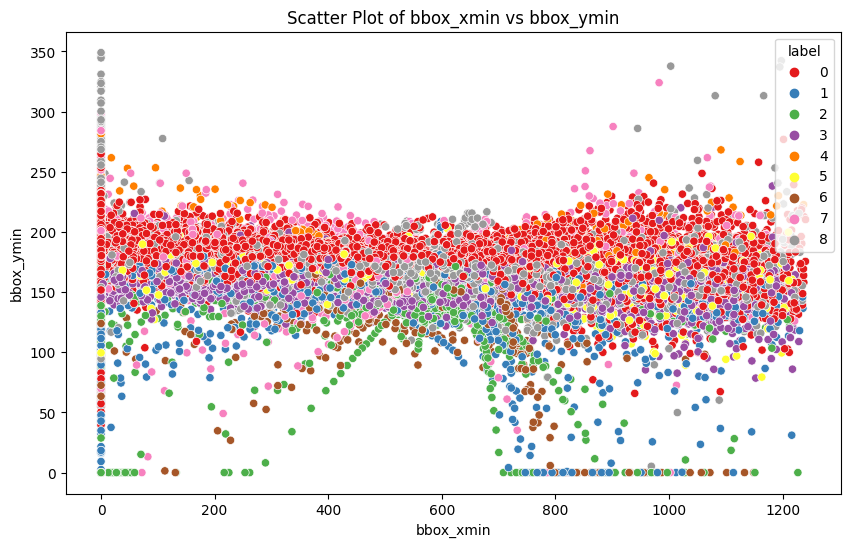

In [34]:
# Function to create scatter plot
def plot_scatter(data, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_col, y=y_col, hue='label', data=data, palette='Set1')
    plt.title(f'Scatter Plot of {x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Example usage
plot_scatter(transformed_data, 'bbox_xmin', 'bbox_ymin')


### Cell 5: Box Plots for Numerical Variables

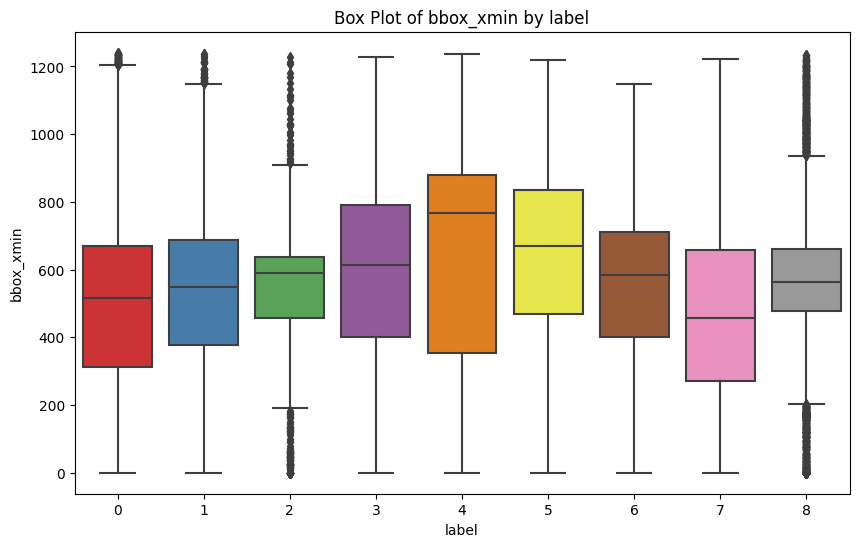

In [35]:
# Function to create box plot
def plot_box(data, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data, palette='Set1')
    plt.title(f'Box Plot of {y_col} by {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

# Example usage
plot_box(transformed_data, 'label', 'bbox_xmin')


## **Data Visualization**

### **1. Class Distribution**

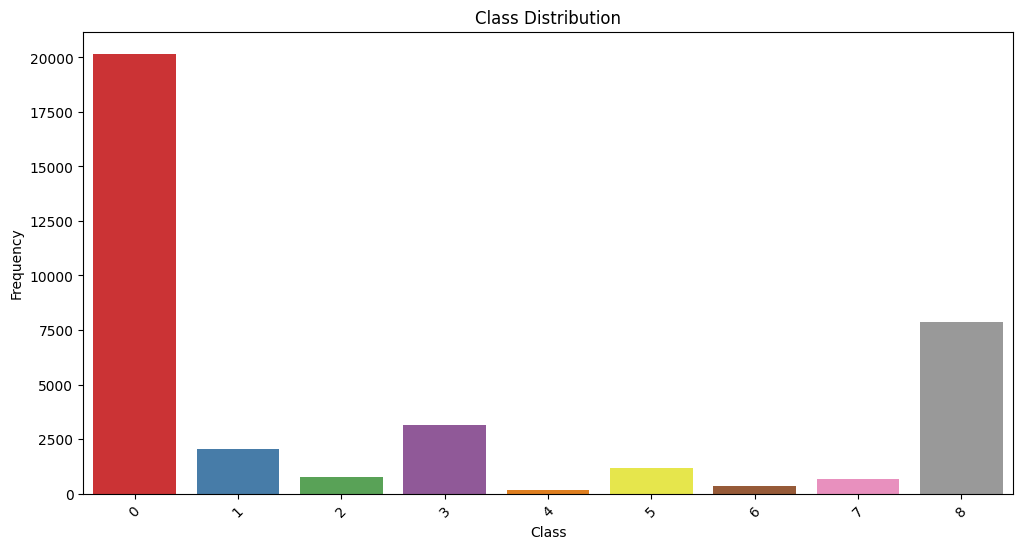

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to visualize class distribution
def visualize_class_distribution(data):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='label', data=data, palette='Set1')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

    
    
# Adding the image_path to the train_data for visualization purposes
#train_data['image_path'] = train_data['image'].apply(lambda x: str(meta.img_path / x))

# Example usage
visualize_class_distribution(train_data)

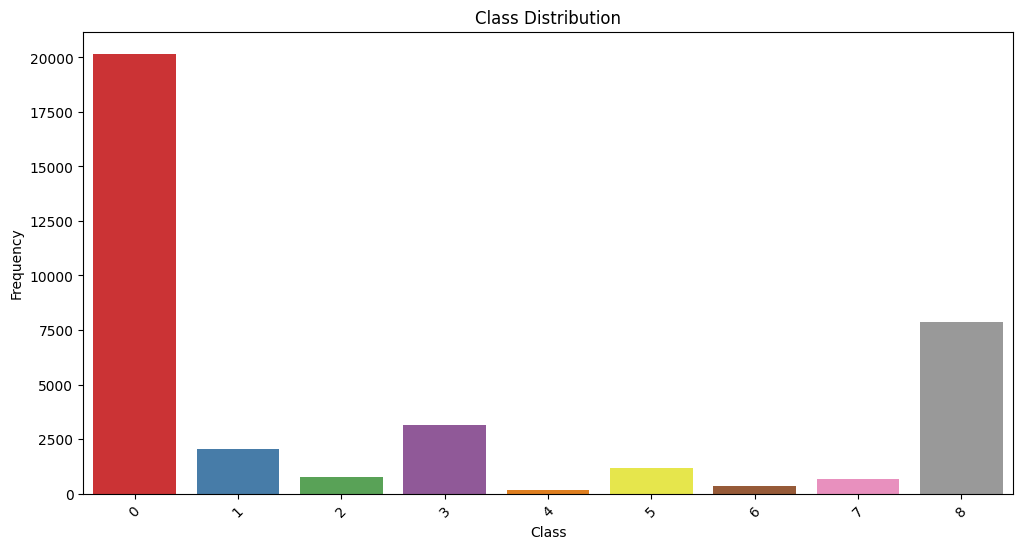

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to visualize class distribution
def visualize_class_distribution(data):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='label', data=data, palette='Set1')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Example usage
visualize_class_distribution(train_data)

### 2. Bounding Box Size Distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


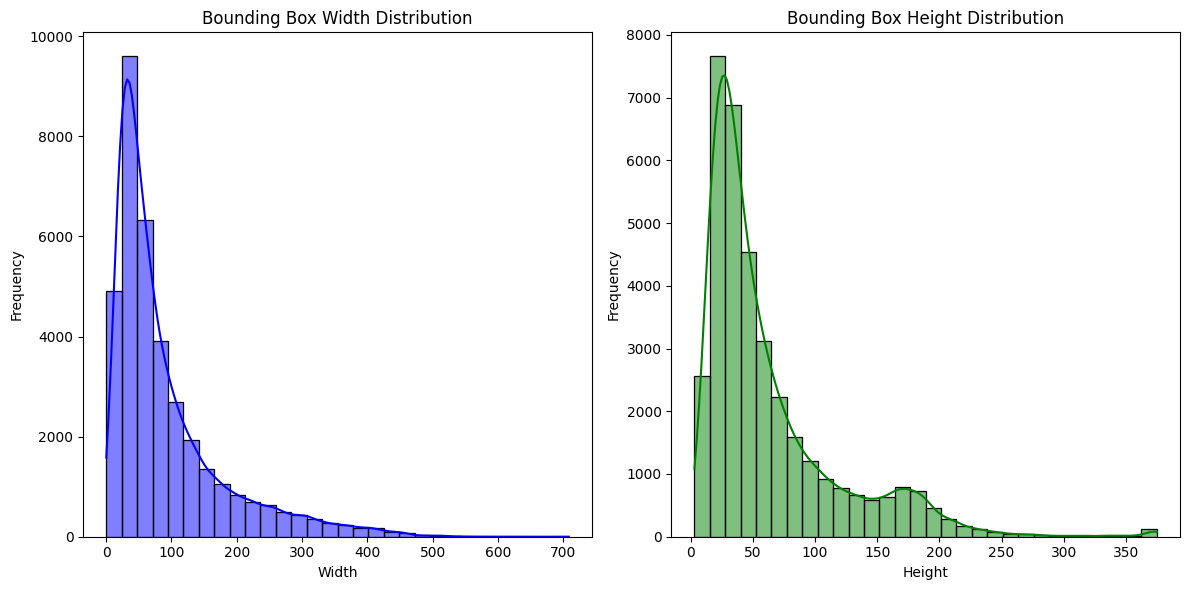

In [38]:
# Calculate bounding box sizes
train_data['bbox_width'] = train_data['bbox_xmax'] - train_data['bbox_xmin']
train_data['bbox_height'] = train_data['bbox_ymax'] - train_data['bbox_ymin']

# Function to visualize bounding box size distribution
def visualize_bbox_size_distribution(data):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(data['bbox_width'], bins=30, kde=True, color='blue')
    plt.title('Bounding Box Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(data['bbox_height'], bins=30, kde=True, color='green')
    plt.title('Bounding Box Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_bbox_size_distribution(train_data)


### 3. Bounding Box Position Distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


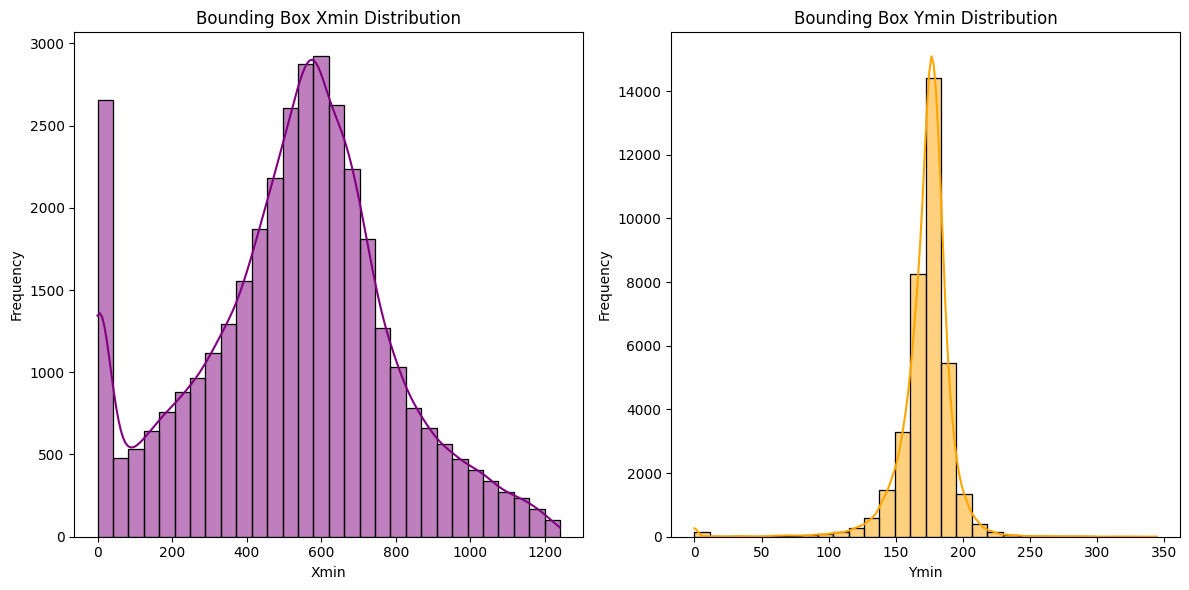

In [39]:
# Function to visualize bounding box position distribution
def visualize_bbox_position_distribution(data):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(data['bbox_xmin'], bins=30, kde=True, color='purple')
    plt.title('Bounding Box Xmin Distribution')
    plt.xlabel('Xmin')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(data['bbox_ymin'], bins=30, kde=True, color='orange')
    plt.title('Bounding Box Ymin Distribution')
    plt.xlabel('Ymin')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_bbox_position_distribution(train_data)


### 4. Correlation Heatmap

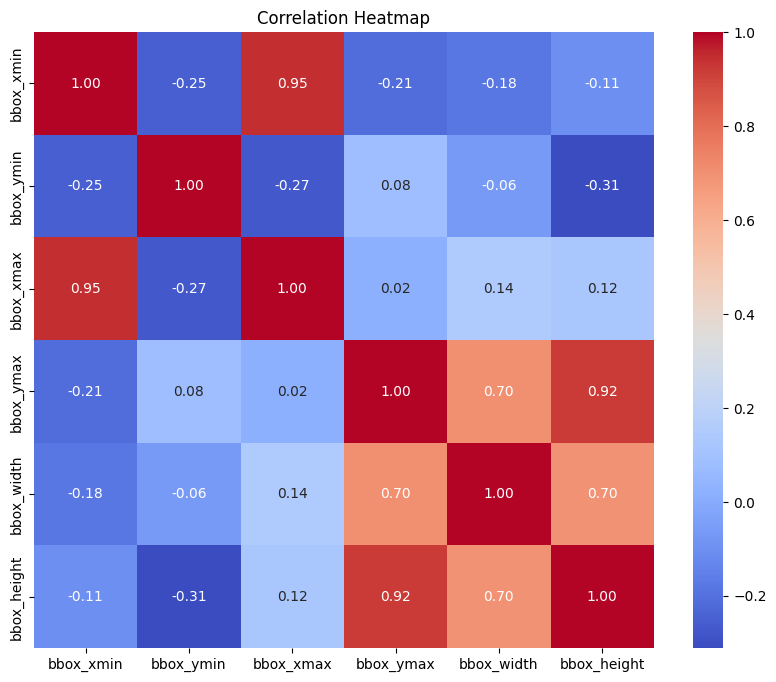

In [40]:
# Function to plot correlation heatmap
def plot_correlation_heatmap(data):
    correlation_matrix = data[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax', 'bbox_width', 'bbox_height']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

# Example usage
plot_correlation_heatmap(train_data)


### 5. Scatter Plots for Bounding Box Positions

In [41]:
# Function to plot scatter plots
def plot_scatter_plots(data):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x='bbox_xmin', y='bbox_ymin', hue='label', data=data, palette='Set1')
    plt.title('Scatter Plot of Bbox Xmin vs Ymin')
    plt.xlabel('Bbox Xmin')
    plt.ylabel('Bbox Ymin')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x='bbox_xmax', y='bbox_ymax', hue='label', data=data, palette='Set1')
    plt.title('Scatter Plot of Bbox Xmax vs Ymax')
    plt.xlabel('Bbox Xmax')
    plt.ylabel('Bbox Ymax')

    plt.tight_layout()
    plt.show()

# Example usage
plot_scatter_plots(train_data)


NameError: name 'z' is not defined

### 6. Box Plots for Bounding Box Sizes by Class

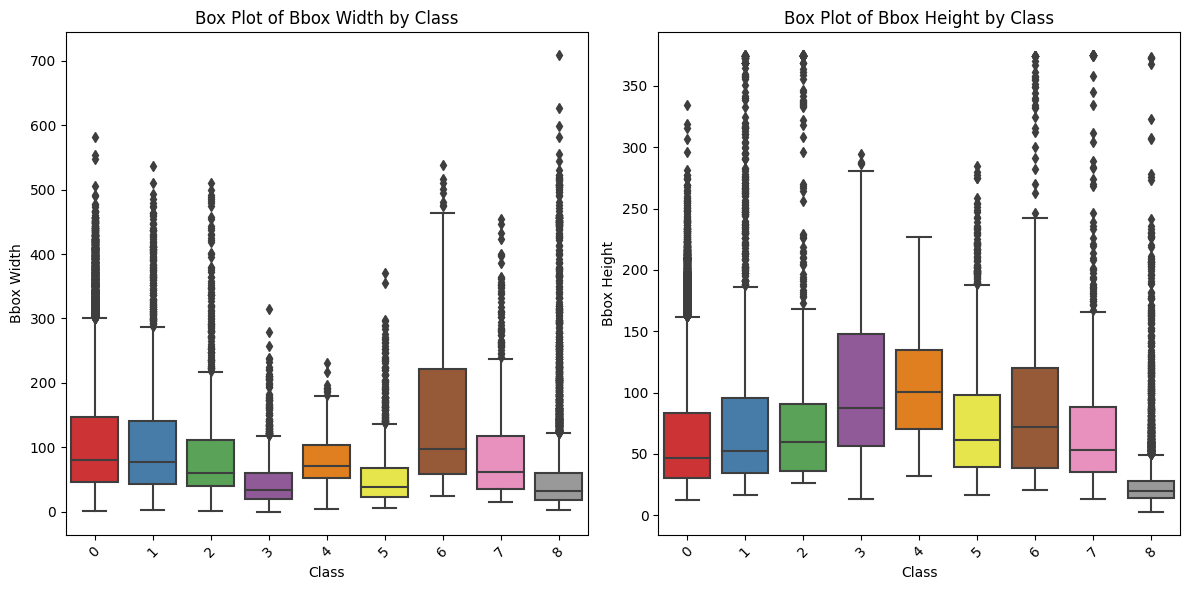

In [42]:
# Function to plot box plots
def plot_box_plots(data):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='label', y='bbox_width', data=data, palette='Set1')
    plt.title('Box Plot of Bbox Width by Class')
    plt.xlabel('Class')
    plt.ylabel('Bbox Width')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.boxplot(x='label', y='bbox_height', data=data, palette='Set1')
    plt.title('Box Plot of Bbox Height by Class')
    plt.xlabel('Class')
    plt.ylabel('Bbox Height')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Example usage
plot_box_plots(train_data)


### 7. Example Images with Bounding Boxes

In [43]:
import pandas as pd
from pathlib import Path
from types import SimpleNamespace
import numpy as np

# Define paths
meta = SimpleNamespace(base_dir = Path('/kaggle/input/kitti-dataset'))
meta.label_path = meta.base_dir / 'data_object_label_2' / 'training' / 'label_2'
meta.label_cols = [
    'label', 'truncated', 'occluded', 'alpha',
    'bbox_xmin', 'bbox_ymin', 'bbox_xmax',
    'bbox_ymax', 'dim_height', 'dim_width', 'dim_length',
    'loc_x', 'loc_y', 'loc_z', 'rotation_y', 'score'
]
columns_to_keep = ['label', 'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']

# Function to eliminate unnecessary variables
def eliminate_variables(label_file):
    data = pd.read_csv(
        label_file,
        sep=" ",
        names=meta.label_cols[:15],
        usecols=meta.label_cols[:15]
    )
    return data[columns_to_keep]

# Process the entire dataset
def process_dataset(label_path):
    all_data = []
    for label_file in label_path.glob('*.txt'):
        filtered_data = eliminate_variables(label_file)
        all_data.append(filtered_data)
    return pd.concat(all_data, ignore_index=True)

# Example usage
processed_data = process_dataset(meta.label_path)
print(processed_data.head())

  label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
0   Car     572.30     185.01     621.87     225.02
1   Car     506.01     182.79     554.75     215.37
2   Car     354.98     183.52     401.03     207.84
3   Car       0.00     185.66     124.97     275.12
4   Van     597.32     165.04     621.59     197.95


In [44]:
# Define mapping for labels to categorical values
label_mapping = {
    'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3, 
    'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Misc': 7, 'DontCare': 8
}

# Function to transform labels into categorical variables
def transform_to_categorical(data):
    data['label'] = data['label'].map(label_mapping)
    return data

# Example usage
transformed_data = transform_to_categorical(processed_data)
print(transformed_data.head())

   label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax
0      0     572.30     185.01     621.87     225.02
1      0     506.01     182.79     554.75     215.37
2      0     354.98     183.52     401.03     207.84
3      0       0.00     185.66     124.97     275.12
4      1     597.32     165.04     621.59     197.95


In [45]:
# Function to treat missing values
def treat_missing_values(data):
    # Example: Fill missing values with the mean of the column
    data = data.fillna(data.mean())
    return data

# Example usage
treated_data = treat_missing_values(transformed_data)
print(treated_data.isnull().sum())

label        0
bbox_xmin    0
bbox_ymin    0
bbox_xmax    0
bbox_ymax    0
dtype: int64


In [46]:
from sklearn.model_selection import train_test_split

# Function to split the dataset
def split_dataset(data, test_size=0.2, val_size=0.1):
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=val_size/(1-test_size), random_state=42)
    return train_data, val_data, test_data

# Example usage
train_data, val_data, test_data = split_dataset(treated_data)
print("Train Data:", train_data.shape)
print("Validation Data:", val_data.shape)
print("Test Data:", test_data.shape)

Train Data: (36305, 5)
Validation Data: (5187, 5)
Test Data: (10373, 5)


In [ ]:
print(transformed_data.head())

# Step 1: Ensure the 'image' column is added

In [47]:
import pandas as pd
from pathlib import Path
from types import SimpleNamespace

# Define paths
meta = SimpleNamespace(base_dir = Path('/kaggle/input/kitti-dataset'))
meta.label_path = meta.base_dir / 'data_object_label_2' / 'training' / 'label_2'
meta.img_path = meta.base_dir / 'data_object_image_2' / 'training' / 'image_2'
meta.label_cols = [
    'label', 'truncated', 'occluded', 'alpha',
    'bbox_xmin', 'bbox_ymin', 'bbox_xmax',
    'bbox_ymax', 'dim_height', 'dim_width', 'dim_length',
    'loc_x', 'loc_y', 'loc_z', 'rotation_y'
]

# Load dataset function
def load_dataset(label_path, label_cols):
    all_data = []
    for label_file in label_path.glob('*.txt'):
        data = pd.read_csv(
            label_file,
            sep=" ",
            names=label_cols,
            usecols=label_cols
        )
        # Extract image filenames from label filenames
        data['image'] = label_file.stem + '.png'
        all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# Eliminate unnecessary variables
def eliminate_variables(data):
    columns_to_keep = ['label', 'bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax', 'image']
    return data[columns_to_keep]

# Transform labels into categorical variables
def transform_to_categorical(data):
    label_mapping = {
        'Car': 0, 'Van': 1, 'Truck': 2, 'Pedestrian': 3, 
        'Person_sitting': 4, 'Cyclist': 5, 'Tram': 6, 'Misc': 7, 'DontCare': 8
    }
    data['label'] = data['label'].map(label_mapping)
    return data

# Identify and treat missing values
def treat_missing_values(data):
    # Treat only numerical columns for missing values
    numerical_cols = ['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']
    data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].mean())
    return data

# Split the dataset
from sklearn.model_selection import train_test_split

def split_dataset(data):
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.1/(0.9+0.1), random_state=42)
    return train_data, val_data, test_data

# Full data preparation pipeline
def prepare_data(label_path, label_cols):
    raw_data = load_dataset(label_path, label_cols)
    processed_data = eliminate_variables(raw_data)
    processed_data = transform_to_categorical(processed_data)
    processed_data = treat_missing_values(processed_data)
    train_data, val_data, test_data = split_dataset(processed_data)
    return train_data, val_data, test_data

# Execute data preparation
train_data, val_data, test_data = prepare_data(meta.label_path, meta.label_cols)

# Check the first few rows of train_data
print(train_data.head())


       label  bbox_xmin  bbox_ymin  bbox_xmax  bbox_ymax       image
24303      0     410.89     183.43     465.31     213.35  000095.png
19273      0     552.27     177.86     572.91     198.02  000235.png
1457       8     518.94     179.19     542.94     193.81  000650.png
49467      0     581.15     180.43     598.61     194.26  004644.png
18285      0     267.28     180.95     433.94     295.88  002841.png


/tmp/ipykernel_34/3067821188.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].map(label_mapping)
/tmp/ipykernel_34/3067821188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].mean())


# Step 2: Visualization Script

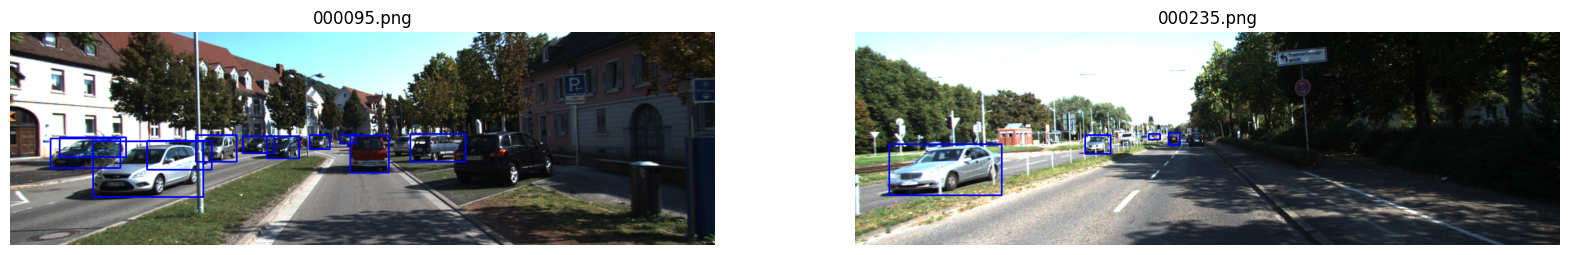

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os

# Function to draw bounding boxes on images
def draw_bounding_boxes(image_path, labels, color=(255, 0, 0)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    for _, row in labels.iterrows():
        cv2.rectangle(image, (int(row['bbox_xmin']), int(row['bbox_ymin'])), 
                      (int(row['bbox_xmax']), int(row['bbox_ymax'])), color, 2)
    return image

# Function to visualize example images with bounding boxes
def visualize_example_images(data, img_base_path, num_images=5):
    plt.figure(figsize=(20, 10))
    unique_images = data['image'].unique()
    for i, img_file in enumerate(unique_images[:num_images]):
        img_path = str(img_base_path / img_file)
        labels = data[data['image'] == img_file]
        image_with_boxes = draw_bounding_boxes(img_path, labels)
        if image_with_boxes is not None:
            plt.subplot(1, num_images, i+1)
            plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(os.path.basename(img_path))
            plt.axis('off')
    plt.show()

# Adding the image_path to the train_data for visualization purposes
train_data['image_path'] = train_data['image'].apply(lambda x: str(meta.img_path / x))

# Example usage
visualize_example_images(train_data, meta.img_path, num_images=2)


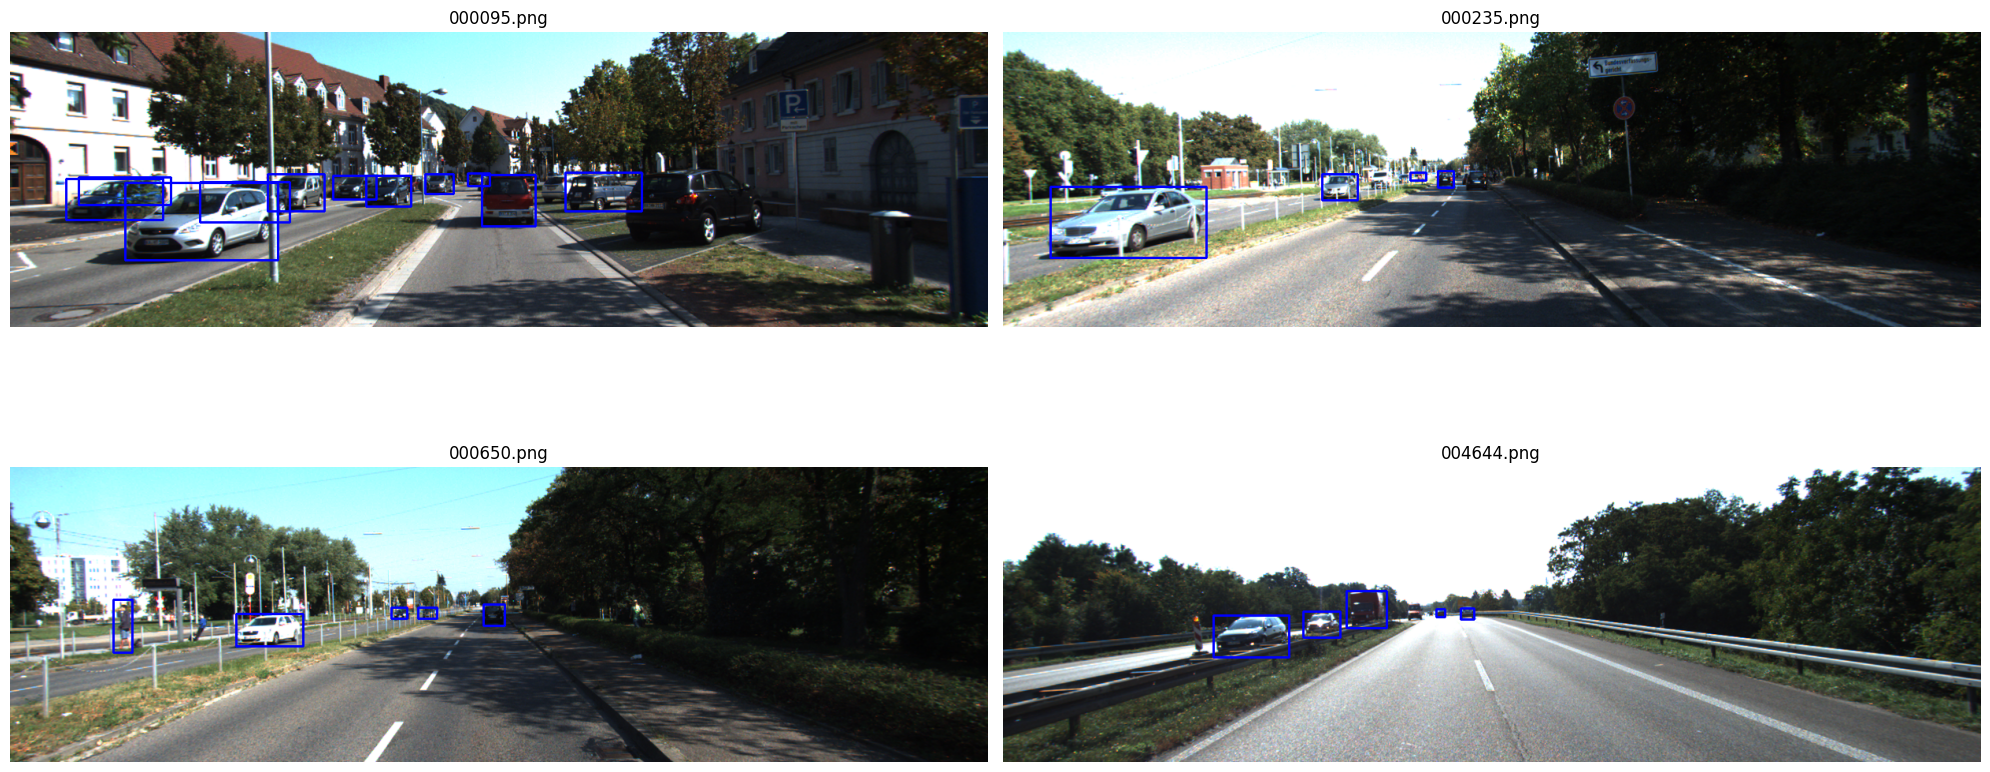

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os

# Function to draw bounding boxes on images
def draw_bounding_boxes(image_path, labels, color=(255, 0, 0)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    for _, row in labels.iterrows():
        cv2.rectangle(image, (int(row['bbox_xmin']), int(row['bbox_ymin'])), 
                      (int(row['bbox_xmax']), int(row['bbox_ymax'])), color, 2)
    return image

# Function to visualize example images with bounding boxes
def visualize_example_images(data, img_base_path, num_images=4):
    plt.figure(figsize=(20, 10))  # Set figure size to make images larger
    unique_images = data['image'].unique()
    for i, img_file in enumerate(unique_images[:num_images]):
        img_path = str(img_base_path / img_file)
        labels = data[data['image'] == img_file]
        image_with_boxes = draw_bounding_boxes(img_path, labels)
        if image_with_boxes is not None:
            plt.subplot(2, 2, i+1)  # Set up 2 rows and 2 columns
            plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
            plt.title(os.path.basename(img_path))
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Adding the image_path to the train_data for visualization purposes
train_data['image_path'] = train_data['image'].apply(lambda x: str(meta.img_path / x))

# Example usage
visualize_example_images(train_data, meta.img_path, num_images=4)


In [50]:
!pip install tqdm

In [51]:
!pip install Pillow

In [52]:
from tqdm import tqdm
import csv
from PIL import Image


all_classes = []

OUT_LABELS_DIR = "labels_with_dont_care"

KEY_DONT_CARE = "DontCare"

class_names = ['Car', 'Pedestrian', 'Van', 'Cyclist', 'Truck', 'Misc', 'Tram', 'Person_sitting', 'DontCare']

CLAZZ_NUMBERS = {
    name: idx for idx,name in enumerate(class_names)
}

def getSampleId(path):
    basename = os.path.basename(path)
    return os.path.splitext(basename)[0]

def resolveClazzNumberOrNone(clazz, use_dont_care):
#     if clazz == KEY_CYCLIST:
#         return CLAZZ_NUMBERS[KEY_CYCLIST]
#     #if clazz in (KEY_PEDESTRIAN, KEY_PERSON_SITTING):
#     if clazz == KEY_PEDESTRIAN:
#         return CLAZZ_NUMBERS[KEY_PEDESTRIAN]
#     #if clazz in (KEY_CAR, KEY_VAN):
#     if clazz == KEY_CAR:
#         return CLAZZ_NUMBERS[KEY_CAR]
#     if use_dont_care and clazz == KEY_DONT_CARE:
#         return CLAZZ_NUMBERS[KEY_DONT_CARE] # These should not be punished.
    if use_dont_care and clazz == KEY_DONT_CARE:
        return CLAZZ_NUMBERS[clazz]
    elif clazz != KEY_DONT_CARE:
        return CLAZZ_NUMBERS[clazz]
    return None

def convertToYoloBBox(bbox, size):
    # Yolo uses bounding bbox coordinates and size relative to the image size.
    # This is taken from https://pjreddie.com/media/files/voc_label.py .
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (bbox[0] + bbox[1]) / 2.0
    y = (bbox[2] + bbox[3]) / 2.0
    w = bbox[1] - bbox[0]
    h = bbox[3] - bbox[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def readRealImageSize(img_path):
    # This loads the whole sample image and returns its size.
    return Image.open(img_path).size

def readFixedImageSize():
    # This is not exact for all images but most (and it should be faster).
    return (1242, 375)

def parseSample(lbl_path, img_path, use_dont_care):
    with open(lbl_path) as csv_file:
        reader = csv.DictReader(csv_file, fieldnames=["type", "truncated", "occluded", "alpha", "bbox2_left", "bbox2_top", "bbox2_right", "bbox2_bottom", "bbox3_height", "bbox3_width", "bbox3_length", "bbox3_x", "bbox3_y", "bbox3_z", "bbox3_yaw", "score"], delimiter=" ")
        yolo_labels = []
        for row in reader:
            all_classes.append(row['type'])
            clazz_number = resolveClazzNumberOrNone(row["type"], use_dont_care)
            if clazz_number is not None:
                size = readRealImageSize(img_path)
                #size = readFixedImageSize()
                # Image coordinate is in the top left corner.
                bbox = (
                        float(row["bbox2_left"]),
                        float(row["bbox2_right"]),
                        float(row["bbox2_top"]),
                        float(row["bbox2_bottom"])
                       )
                yolo_bbox = convertToYoloBBox(bbox, size)
                # Yolo expects the labels in the form:
                # <object-class> <x> <y> <width> <height>.
                yolo_label = (clazz_number,) + yolo_bbox
                yolo_labels.append(yolo_label)
    return yolo_labels


args = SimpleNamespace(
    label_dir = str(meta.label_path),
    image_2_dir = str(meta.img_path),
    training_samples = 1,
    use_dont_care = True
)

if not os.path.exists(OUT_LABELS_DIR):
    os.makedirs(OUT_LABELS_DIR)

print("Generating darknet labels...")
sample_img_pathes = []
for dir_path, sub_dirs, files in os.walk(args.label_dir):
    for file_name in tqdm(files):
        if file_name.endswith(".txt"):
            lbl_path = os.path.join(dir_path, file_name)
            sample_id = getSampleId(lbl_path)
            img_path = os.path.join(args.image_2_dir, "{}.png".format(sample_id))
            sample_img_pathes.append(img_path)
            yolo_labels = parseSample(lbl_path, img_path, args.use_dont_care)
            with open(os.path.join(OUT_LABELS_DIR, "{}.txt".format(sample_id)), "w") as yolo_label_file:
                for lbl in yolo_labels:
                    yolo_label_file.write("{} {} {} {} {}\n".format(*lbl))

Generating darknet labels...


100%|██████████| 7481/7481 [00:41<00:00, 181.31it/s]


In [53]:
import json

In [54]:
with open('classes_with_dont_care.json','w') as f:
    json.dump(CLAZZ_NUMBERS,f)

In [ ]:
!ls -ltr

In [ ]:
!pwd

In [ ]:
!du -h --max-depth=5

In [ ]:
#!ls -ltr /kaggle/working

In [ ]:
#!rm -rf /kaggle/working/*

In [55]:
CLAZZ_NUMBERS

{'Car': 0,
 'Pedestrian': 1,
 'Van': 2,
 'Cyclist': 3,
 'Truck': 4,
 'Misc': 5,
 'Tram': 6,
 'Person_sitting': 7,
 'DontCare': 8}

In [ ]:
!ls -ltr /kaggle/working

In [56]:
!pip install ultralytics -q

In [57]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [58]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import shutil
from PIL import Image

In [ ]:
!find / -name classes_with_dont_care.json

In [ ]:
!ls -ltr /kaggle/input/kitti-dataset/data_object_image_2/training

In [ ]:
!ls -ltr /kaggle/labels_with_dont_care

In [59]:
base_dir = Path('/kaggle/input/kitti-dataset')
img_path = base_dir / 'data_object_image_2' / 'training' / 'image_2'
label_path = Path('/kaggle/working/labels_with_dont_care')
with open('classes_with_dont_care.json','r') as f:
    classes = json.load(f)

classes

{'Car': 0,
 'Pedestrian': 1,
 'Van': 2,
 'Cyclist': 3,
 'Truck': 4,
 'Misc': 5,
 'Tram': 6,
 'Person_sitting': 7,
 'DontCare': 8}

In [60]:
ims = sorted(list(img_path.glob('*')))
labels = sorted(list(label_path.glob('*')))
pairs = list(zip(ims,labels))
pairs[:2]

[(PosixPath('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000000.png'),
  PosixPath('/kaggle/working/labels_with_dont_care/000000.txt')),
 (PosixPath('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000001.png'),
  PosixPath('/kaggle/working/labels_with_dont_care/000001.txt'))]

In [61]:
ims = sorted(list(img_path.glob('*')))
labels = sorted(list(label_path.glob('*')))
pairs = list(zip(ims,labels))
pairs[:2]

[(PosixPath('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000000.png'),
  PosixPath('/kaggle/working/labels_with_dont_care/000000.txt')),
 (PosixPath('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000001.png'),
  PosixPath('/kaggle/working/labels_with_dont_care/000001.txt'))]

In [ ]:
#print(len(test))

In [62]:
train, test = train_test_split(pairs,test_size=0.1,shuffle=True)
len(train), len(test)

(6732, 749)

In [ ]:
#print(len(train_path))

In [63]:
train_path = Path('train').resolve()
train_path.mkdir(exist_ok=True)
valid_path = Path('valid').resolve()
valid_path.mkdir(exist_ok=True)

In [64]:
for t_img, t_lb in tqdm(train):
    im_path = train_path / t_img.name
    lb_path = train_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/6732 [00:00<?, ?it/s]

In [65]:
for t_img, t_lb in tqdm(test):
    im_path = valid_path / t_img.name
    lb_path = valid_path / t_lb.name
    shutil.copy(t_img,im_path)
    shutil.copy(t_lb,lb_path)

  0%|          | 0/749 [00:00<?, ?it/s]

## **YAML file for the data**

In [66]:
yaml_file = 'names:\n'
yaml_file += '\n'.join(f'- {c}' for c in classes)
yaml_file += f'\nnc: {len(classes)}'
yaml_file += f'\ntrain: {str(train_path)}\nval: {str(valid_path)}'
with open('kitti.yaml','w') as f:
    f.write(yaml_file)

In [67]:
!cat kitti.yaml

names:
- Car
- Pedestrian
- Van
- Cyclist
- Truck
- Misc
- Tram
- Person_sitting
- DontCare
nc: 9
train: /kaggle/working/train
val: /kaggle/working/valid

In [ ]:
!pwd

In [ ]:
!ls -ltr 

## **Model**

In [68]:
import torch
torch.cuda.is_available()

True

In [ ]:
#!conda install -y gdown

In [ ]:
#import gdown 
#url = 'https://drive.google.com/file/d/1RHks_eSjhjHDC8YBrs0T4DyLVIVNpT3G' 
#output = 'roadlane_trained_model.pt'
#gdown.download(url, output)


In [ ]:
#pip install --upgrade --no-cache-dir gdown
#!ls -ltr /kaggle/input/
#!mkdir /kaggle/working/yarra
#!mv /kaggle/working/roadlane_trained_model.pt /kaggle/working/yarra

In [ ]:
#!ls -ltr /kaggle/working/yarra

In [69]:
model = YOLO('yolov8n.yaml')
#model = YOLO('/kaggle/working/yarra/roadlane_trained_model.pt')

## **Training**

In [70]:
train_results = model.train(
    data='kitti.yaml', # Path to the dataset configuration file,
    epochs=300, # Increased epochs
    patience=0, # No early stopping
    batch=16,# Batch size
    imgsz=640,  # Image size
    mixup=0.1,# Mixup augmentation factor
    project='Yarra-yolov8n-kitti', # Project name
    name='object_june1401_training_eda',# Naming the experiment
    device=0)# Use GPU if available, specified as a string

Ultralytics YOLOv8.2.32 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=kitti.yaml, epochs=300, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=Yarra-yolov8n-kitti, name=object_june1401_training_eda, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

100%|██████████| 755k/755k [00:00<00:00, 22.1MB/s]
2024-06-14 03:20:18,296	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-14 03:20:19,094	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 128MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train... 6732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6732/6732 [00:34<00:00, 193.71it/s]


train: New cache created: /kaggle/working/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/valid... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:03<00:00, 218.88it/s]


val: New cache created: /kaggle/working/valid.cache
Plotting labels to Yarra-yolov8n-kitti/object_june1401_training_eda/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to Yarra-yolov8n-kitti/object_june1401_training_eda
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.69G      3.827      4.266      3.722        195        640: 100%|██████████| 421/421 [01:34<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.69it/s]

                   all        749       5095      0.912     0.0272     0.0157    0.00507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.55G      2.688      2.603      2.266        171        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.49it/s]


                   all        749       5095      0.414     0.0944     0.0681     0.0268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.81G      2.236      2.122      1.858        189        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.46it/s]


                   all        749       5095        0.4      0.143      0.135     0.0656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300       2.5G      2.008      1.842      1.681        191        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


                   all        749       5095      0.315      0.236      0.182     0.0943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.48G      1.841       1.62      1.559        196        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.74it/s]


                   all        749       5095      0.393      0.249      0.237      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.63G      1.724      1.461      1.481        180        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]


                   all        749       5095      0.404      0.279      0.247      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.65G       1.65      1.369      1.436        198        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.50it/s]


                   all        749       5095      0.456      0.322      0.303      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.39G      1.591      1.305      1.398        212        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.72it/s]


                   all        749       5095      0.512      0.318      0.338      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.65G      1.545       1.24      1.373        178        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.17it/s]


                   all        749       5095      0.527      0.348      0.359      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.56G      1.507      1.195      1.345        195        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.14it/s]


                   all        749       5095      0.561      0.343      0.367      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.58G      1.482      1.165      1.334        205        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.36it/s]


                   all        749       5095      0.561       0.36      0.378      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.82G      1.454      1.128      1.315        223        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.67it/s]


                   all        749       5095      0.563      0.387      0.408      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.73G      1.424      1.096      1.299        109        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]


                   all        749       5095      0.392      0.442       0.42       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.56G        1.4      1.068      1.282        177        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.62it/s]


                   all        749       5095      0.475       0.46      0.457      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.69G      1.389       1.05      1.272        179        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.72it/s]


                   all        749       5095      0.643      0.391      0.488      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300       2.3G      1.374      1.038      1.267        298        640:  23%|██▎       | 98/421 [00:19<01:04,  5.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


                   all        749       5095       0.65      0.413      0.488       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.47G      1.349      1.016      1.254        168        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.58it/s]


                   all        749       5095      0.608      0.427      0.476      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.62G      1.343      1.006      1.248        165        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.09it/s]


                   all        749       5095      0.628       0.46      0.515        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.66G       1.33     0.9875      1.239        236        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.23it/s]


                   all        749       5095      0.593      0.497      0.524      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.61G      1.319     0.9784      1.232        171        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.75it/s]


                   all        749       5095      0.528       0.54      0.546      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.54G      1.308     0.9614      1.224        199        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]


                   all        749       5095      0.639      0.477      0.534       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.62G      1.296     0.9527      1.221        173        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.73it/s]

                   all        749       5095      0.638      0.527      0.563      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.82G      1.291     0.9494      1.216        159        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]

                   all        749       5095      0.651      0.498       0.57      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.45G      1.288     0.9364       1.21        178        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.59it/s]


                   all        749       5095      0.716      0.477      0.584      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.46G      1.275     0.9256      1.206        229        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


                   all        749       5095      0.597      0.557      0.583       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300       2.6G      1.259     0.9084      1.201        141        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]

                   all        749       5095      0.622       0.54       0.58      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.92G      1.269     0.9164      1.202        241        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.59it/s]

                   all        749       5095      0.685      0.521      0.588      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.58G      1.248     0.8986      1.196        209        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]


                   all        749       5095       0.71      0.541      0.615      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.47G      1.241      0.889      1.189        207        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]


                   all        749       5095      0.684      0.549      0.613      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.91G      1.239     0.8829      1.182        154        640: 100%|██████████| 421/421 [01:25<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.53it/s]


                   all        749       5095      0.677      0.544      0.615      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.92G      1.241     0.8849       1.18        193        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.65it/s]


                   all        749       5095      0.664      0.574      0.625      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.51G      1.225     0.8672      1.172        194        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.47it/s]


                   all        749       5095       0.71      0.531      0.621      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.68G      1.215     0.8588      1.169        142        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]

                   all        749       5095       0.66      0.579      0.635      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.55G      1.213     0.8544      1.169        193        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]


                   all        749       5095       0.71      0.578      0.648      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.34G      1.207     0.8522      1.169        273        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.70it/s]


                   all        749       5095       0.76      0.547      0.637      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.45G      1.212     0.8571      1.169        179        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.67it/s]


                   all        749       5095      0.698      0.605      0.658      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300       2.6G      1.204     0.8503      1.165        262        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]

                   all        749       5095      0.715      0.577      0.653      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.49G      1.195     0.8412       1.16        192        640: 100%|██████████| 421/421 [01:25<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]


                   all        749       5095      0.679      0.585      0.644      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.71G      1.183     0.8241      1.155        198        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.90it/s]


                   all        749       5095       0.69       0.62      0.673      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.49G      1.186     0.8312      1.156        216        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.60it/s]


                   all        749       5095      0.647      0.624      0.662      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.45G      1.184     0.8242      1.152        171        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


                   all        749       5095      0.744      0.577      0.675      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.69G      1.184     0.8309      1.155        180        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]


                   all        749       5095      0.704      0.582      0.661      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.67G      1.172     0.8136      1.146        170        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.91it/s]


                   all        749       5095      0.697       0.61      0.674       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.67G      1.171     0.8124      1.145        178        640: 100%|██████████| 421/421 [01:28<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.74it/s]

                   all        749       5095      0.753      0.605      0.693      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.47G      1.165     0.8053      1.141        222        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.67it/s]


                   all        749       5095      0.727       0.63      0.696      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.75G      1.164     0.8043      1.143        157        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.56it/s]


                   all        749       5095      0.732      0.639      0.702      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.55G      1.164     0.8058      1.142        168        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.37it/s]


                   all        749       5095      0.746      0.609      0.683      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300       2.6G      1.159     0.8007      1.137        221        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]


                   all        749       5095      0.818      0.583      0.698      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.59G      1.156     0.7972      1.137        227        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.21it/s]

                   all        749       5095      0.802      0.593      0.708      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.38G      1.146     0.7878      1.128        201        640: 100%|██████████| 421/421 [01:25<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.74it/s]


                   all        749       5095      0.704      0.639        0.7      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.55G       1.14     0.7855      1.131        262        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.79it/s]


                   all        749       5095      0.709       0.66      0.707      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.72G      1.143     0.7873      1.133        148        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.75it/s]

                   all        749       5095      0.725      0.666       0.72      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.68G      1.142     0.7813      1.128        208        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.60it/s]

                   all        749       5095      0.771      0.622      0.714      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.61G       1.14     0.7832      1.128        212        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.87it/s]

                   all        749       5095      0.774      0.622      0.716      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.57G      1.129     0.7703      1.122        216        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.70it/s]


                   all        749       5095      0.766      0.636      0.713      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300       2.6G      1.125     0.7661       1.12        167        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.53it/s]

                   all        749       5095      0.747      0.656      0.718      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.59G      1.126     0.7654      1.118        229        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.42it/s]


                   all        749       5095      0.766      0.671      0.732      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.61G      1.123     0.7626      1.117        168        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.15it/s]

                   all        749       5095      0.765      0.662       0.73      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.52G      1.116     0.7575      1.114        134        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]

                   all        749       5095      0.747      0.658      0.724      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.62G      1.111     0.7585      1.113        143        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


                   all        749       5095      0.761      0.663      0.727      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.44G      1.117     0.7603       1.12        181        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.51it/s]


                   all        749       5095      0.765      0.674      0.735      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.48G      1.116     0.7586      1.115        195        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]

                   all        749       5095        0.8      0.624      0.724      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.48G      1.111     0.7536      1.115        143        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.60it/s]

                   all        749       5095      0.729      0.674      0.732      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.69G      1.108     0.7529      1.112        189        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.69it/s]

                   all        749       5095      0.745      0.674      0.731      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.66G      1.109     0.7527      1.116        145        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.51it/s]


                   all        749       5095      0.717      0.696      0.736      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.57G        1.1     0.7448      1.107        190        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.44it/s]

                   all        749       5095      0.785      0.654      0.737      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.59G      1.102     0.7455      1.106        233        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


                   all        749       5095      0.746      0.693      0.742      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.46G        1.1     0.7454      1.109        226        640: 100%|██████████| 421/421 [01:26<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]


                   all        749       5095      0.793      0.674      0.746      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300       2.7G      1.102     0.7422      1.106        150        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.19it/s]

                   all        749       5095      0.802      0.671      0.743      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.61G        1.1     0.7428      1.103        218        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]

                   all        749       5095       0.76      0.683      0.743      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.48G      1.096     0.7401      1.104        213        640: 100%|██████████| 421/421 [01:27<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.49it/s]

                   all        749       5095      0.841      0.638      0.741      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.52G      1.088      0.727      1.101        202        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]


                   all        749       5095       0.77      0.695      0.744      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.35G      1.084     0.7289      1.098        226        640: 100%|██████████| 421/421 [01:26<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.59it/s]

                   all        749       5095      0.753        0.7       0.75      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.62G      1.083     0.7257      1.096        186        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.37it/s]

                   all        749       5095      0.737      0.695      0.743        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.47G      1.083     0.7276      1.097        192        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.51it/s]

                   all        749       5095      0.726      0.706       0.75      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.67G      1.084     0.7266      1.095        116        640: 100%|██████████| 421/421 [01:27<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.46it/s]


                   all        749       5095       0.74      0.706      0.749      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.52G      1.086     0.7293      1.098        237        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.18it/s]


                   all        749       5095      0.731      0.695      0.748      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      2.45G      1.079     0.7251      1.092        117        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.62it/s]


                   all        749       5095      0.802       0.66      0.748      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      2.45G      1.076     0.7225      1.093        144        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.67it/s]

                   all        749       5095      0.785      0.675      0.741      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      2.45G      1.074     0.7199      1.092        231        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.70it/s]

                   all        749       5095      0.727      0.705      0.749      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      2.47G      1.079     0.7222      1.093        205        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.56it/s]

                   all        749       5095      0.747      0.697      0.747      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      2.46G      1.073     0.7146      1.089        207        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.37it/s]

                   all        749       5095      0.722      0.727      0.755      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      2.53G      1.078     0.7179      1.095        196        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]

                   all        749       5095       0.77      0.693      0.758      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      2.46G      1.068     0.7111      1.087        134        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.67it/s]


                   all        749       5095      0.778      0.691      0.754      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300       2.6G      1.067     0.7134      1.086        206        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]


                   all        749       5095      0.827      0.669      0.758      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      2.45G      1.062     0.7096      1.087        180        640: 100%|██████████| 421/421 [01:27<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.44it/s]


                   all        749       5095       0.84      0.657      0.758      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      2.46G      1.058     0.7037      1.084        169        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.38it/s]


                   all        749       5095      0.778      0.687      0.754      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      2.76G      1.064     0.7058      1.085        156        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.66it/s]


                   all        749       5095      0.759       0.69      0.753      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      2.44G      1.063     0.7074      1.083        232        640: 100%|██████████| 421/421 [01:27<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.56it/s]


                   all        749       5095       0.78      0.689      0.756      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      2.48G      1.056     0.6972      1.084        168        640: 100%|██████████| 421/421 [01:27<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.68it/s]


                   all        749       5095      0.798      0.695      0.759      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      2.63G      1.061     0.7034      1.085        140        640: 100%|██████████| 421/421 [01:27<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]

                   all        749       5095       0.81      0.676       0.76       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      2.61G      1.055     0.7017      1.078        188        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.71it/s]

                   all        749       5095      0.795      0.683      0.762      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      2.48G      1.068     0.7104      1.079        141        640: 100%|██████████| 421/421 [01:27<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.72it/s]


                   all        749       5095      0.816      0.685      0.767      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      2.45G      1.066     0.7112      1.078        170        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.26it/s]

                   all        749       5095      0.841      0.662      0.765      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      2.61G      1.062      0.707      1.075        238        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]

                   all        749       5095      0.798      0.677      0.765      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      2.71G      1.063     0.7092      1.076        151        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]

                   all        749       5095      0.743      0.711      0.766      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      2.64G      1.066     0.7083      1.075        191        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.14it/s]

                   all        749       5095      0.837      0.664      0.764      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      2.56G      1.063     0.7089      1.072        232        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.59it/s]

                   all        749       5095      0.739      0.719      0.768      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      2.45G      1.063     0.7086       1.07        198        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]

                   all        749       5095       0.72      0.721      0.763      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      2.28G      1.061      0.712       1.07        166        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


                   all        749       5095      0.742      0.716      0.765      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      2.64G      1.062     0.7115       1.07        176        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]


                   all        749       5095      0.721      0.731      0.768       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      2.47G      1.058     0.7078      1.066        197        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.47it/s]

                   all        749       5095      0.797      0.683      0.771      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      2.28G      1.064     0.7106      1.065        175        640: 100%|██████████| 421/421 [01:27<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.45it/s]

                   all        749       5095      0.736      0.724      0.775      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      2.79G      1.062     0.7134      1.065        211        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.57it/s]


                   all        749       5095      0.753      0.724      0.773      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      2.48G      1.052      0.706      1.061        148        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.37it/s]

                   all        749       5095      0.742      0.738      0.772      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      2.78G      1.052      0.702      1.062        180        640: 100%|██████████| 421/421 [01:28<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.41it/s]


                   all        749       5095      0.755      0.719      0.773      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      2.64G      1.046     0.7006      1.059        141        640: 100%|██████████| 421/421 [01:27<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.41it/s]


                   all        749       5095      0.752      0.725      0.774      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      2.92G      1.059     0.7068      1.062        113        640: 100%|██████████| 421/421 [01:28<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.66it/s]

                   all        749       5095      0.746      0.727      0.774      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      2.48G      1.043     0.6982      1.056        265        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]


                   all        749       5095      0.769      0.714      0.775      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      2.66G      1.048     0.7043       1.06        217        640: 100%|██████████| 421/421 [01:27<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.39it/s]


                   all        749       5095      0.766      0.712      0.772      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      2.72G      1.051      0.701      1.059        173        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.26it/s]


                   all        749       5095      0.782      0.707      0.776      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      2.88G      1.045     0.6971      1.057        170        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]

                   all        749       5095      0.788        0.7      0.776      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      2.64G      1.044     0.6941      1.054        211        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.60it/s]


                   all        749       5095       0.73      0.748       0.78      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      2.44G      1.042      0.693      1.052        162        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]

                   all        749       5095      0.745      0.736      0.782      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      2.78G      1.039     0.6959      1.052        138        640: 100%|██████████| 421/421 [01:26<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.82it/s]


                   all        749       5095       0.76      0.724      0.782      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      2.65G      1.038     0.6946      1.052        156        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.64it/s]


                   all        749       5095      0.741      0.732      0.783      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      2.45G      1.034     0.6894      1.051        172        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]

                   all        749       5095      0.835      0.681      0.783      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      2.54G      1.038     0.6893       1.05        223        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.45it/s]


                   all        749       5095      0.829      0.694      0.784      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      2.78G      1.038     0.6961      1.051        184        640: 100%|██████████| 421/421 [01:27<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.43it/s]

                   all        749       5095      0.797      0.704      0.785      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      2.61G      1.032     0.6844      1.046        213        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.75it/s]

                   all        749       5095      0.845      0.685      0.786      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      2.31G      1.035     0.6889      1.049        228        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]


                   all        749       5095      0.839      0.686      0.787      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300       2.6G       1.03     0.6866      1.051        233        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.40it/s]

                   all        749       5095      0.806      0.695      0.785      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      2.48G      1.033     0.6881      1.046        163        640: 100%|██████████| 421/421 [01:25<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.70it/s]


                   all        749       5095      0.836      0.696      0.788      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300       2.6G      1.035     0.6898      1.051        249        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]


                   all        749       5095      0.838      0.697       0.79      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      2.67G      1.022     0.6803      1.043        217        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.62it/s]

                   all        749       5095      0.822      0.702      0.789      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      2.32G      1.028     0.6856      1.047        203        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]


                   all        749       5095      0.845       0.69       0.79      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      2.51G       1.03     0.6845      1.044        165        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.64it/s]

                   all        749       5095      0.846      0.686      0.789       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      2.56G      1.018     0.6733       1.04        122        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.49it/s]

                   all        749       5095       0.85      0.684      0.791      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      2.56G       1.02     0.6775      1.039        215        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.79it/s]

                   all        749       5095      0.788      0.719       0.79      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300       2.6G      1.014     0.6727      1.038        203        640: 100%|██████████| 421/421 [01:25<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.18it/s]


                   all        749       5095      0.791      0.725      0.792      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      2.75G      1.015     0.6708      1.035        181        640: 100%|██████████| 421/421 [01:25<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.67it/s]


                   all        749       5095      0.814      0.711      0.792      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      2.49G      1.016     0.6718      1.038        206        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.68it/s]

                   all        749       5095      0.785      0.722      0.793      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      2.68G       1.02     0.6765      1.039        210        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]

                   all        749       5095      0.796       0.72      0.792      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      2.63G      1.016     0.6721      1.034        152        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
    137/300      2.47G      1.017      0.673       1.04        164        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.51it/s]


                   all        749       5095      0.785      0.729      0.794      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      2.75G       1.01     0.6689      1.035        177        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.74it/s]

                   all        749       5095      0.767      0.739      0.795      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      2.64G      1.013     0.6737      1.036        110        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.53it/s]

                   all        749       5095      0.765      0.741      0.795      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      2.63G      1.007     0.6651      1.037        125        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.77it/s]


                   all        749       5095       0.76      0.752      0.795      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300       2.6G       1.01      0.664      1.034        221        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]

                   all        749       5095      0.761      0.752      0.797       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      2.45G      1.004     0.6627      1.032        226        640: 100%|██████████| 421/421 [01:25<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.75it/s]


                   all        749       5095      0.775      0.742      0.796      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      2.46G      1.005     0.6628      1.031        232        640: 100%|██████████| 421/421 [01:25<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]


                   all        749       5095      0.786      0.733      0.797       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      2.83G      1.002     0.6595       1.03        185        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.60it/s]

                   all        749       5095      0.767       0.75      0.799      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      2.53G      1.007     0.6649      1.035        197        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]


                   all        749       5095      0.756      0.753      0.798      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      2.62G      1.004     0.6632       1.03        184        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]

                   all        749       5095      0.759      0.754        0.8      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      2.63G      1.001     0.6604       1.03        209        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.58it/s]


                   all        749       5095      0.784      0.748      0.801      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      2.55G      1.003     0.6603      1.028        190        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.68it/s]

                   all        749       5095      0.776      0.749        0.8      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      2.56G      1.001     0.6563      1.028        273        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]

                   all        749       5095      0.776      0.751      0.801      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      2.74G     0.9976     0.6587      1.028        190        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.24it/s]


                   all        749       5095      0.791      0.745      0.801      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      2.75G     0.9881     0.6465      1.019        193        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.77it/s]

                   all        749       5095      0.798      0.748      0.801      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      2.62G     0.9965     0.6531      1.024        207        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]

                   all        749       5095        0.8      0.745        0.8      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      2.44G     0.9933     0.6509      1.022        182        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]

                   all        749       5095      0.804      0.741      0.801      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      2.45G     0.9887     0.6496      1.025        199        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.23it/s]


                   all        749       5095      0.806      0.738      0.801      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      2.56G     0.9865     0.6486      1.023        167        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.20it/s]

                   all        749       5095      0.798      0.743      0.801      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      2.68G     0.9797     0.6432      1.019        200        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.51it/s]


                   all        749       5095       0.78      0.754      0.803      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      2.88G     0.9854     0.6461      1.021        180        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.79it/s]


                   all        749       5095      0.798      0.739        0.8      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      2.74G     0.9814     0.6423      1.017        161        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.53it/s]


                   all        749       5095       0.79      0.744      0.802      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      2.72G      0.987     0.6455       1.02        196        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]

                   all        749       5095      0.796      0.746      0.803      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      2.48G      0.983     0.6431      1.019        194        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.67it/s]

                   all        749       5095      0.786      0.746        0.8      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      2.72G     0.9808     0.6405      1.016        134        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.71it/s]


                   all        749       5095      0.799      0.739      0.801      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      2.68G     0.9788     0.6383      1.019        179        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.58it/s]

                   all        749       5095      0.784      0.748      0.802      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      2.71G     0.9817     0.6406      1.018        140        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]

                   all        749       5095      0.775       0.75      0.801      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      2.51G     0.9746     0.6366      1.013        119        640: 100%|██████████| 421/421 [01:24<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.12it/s]

                   all        749       5095      0.779      0.751      0.801      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      2.68G     0.9756     0.6358      1.013        165        640: 100%|██████████| 421/421 [01:25<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.58it/s]

                   all        749       5095      0.779      0.751      0.802       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      2.51G      0.981     0.6443      1.018        218        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.68it/s]

                   all        749       5095      0.778      0.751      0.802       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      2.51G     0.9769     0.6399      1.017        233        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.43it/s]

                   all        749       5095      0.789      0.749      0.804       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      2.37G      0.976     0.6386      1.014        205        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.81it/s]

                   all        749       5095      0.794      0.749      0.806      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      2.63G     0.9729      0.633      1.013        160        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.57it/s]


                   all        749       5095      0.792      0.747      0.805      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      2.68G     0.9711     0.6354      1.014        144        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.58it/s]

                   all        749       5095      0.794      0.746      0.805      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      2.69G     0.9715     0.6344       1.01        231        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.58it/s]

                   all        749       5095      0.794      0.743      0.804      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      2.55G     0.9672     0.6305      1.008        185        640: 100%|██████████| 421/421 [01:25<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]

                   all        749       5095      0.797      0.742      0.804      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      2.64G     0.9735     0.6365      1.013        186        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]


                   all        749       5095      0.794      0.745      0.805      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300       2.5G     0.9624     0.6286      1.011        186        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.59it/s]

                   all        749       5095      0.796      0.744      0.805      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      2.67G     0.9647     0.6338      1.009        122        640: 100%|██████████| 421/421 [01:27<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.42it/s]

                   all        749       5095      0.792      0.745      0.806      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      2.61G      0.964     0.6297       1.01        171        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]

                   all        749       5095      0.797      0.745      0.807      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      2.45G     0.9635     0.6264      1.006        199        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.46it/s]


                   all        749       5095      0.797      0.745      0.807      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300       2.6G     0.9627     0.6304      1.009        175        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]

                   all        749       5095      0.794      0.746      0.807      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      2.77G     0.9579     0.6244      1.011        199        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.38it/s]

                   all        749       5095      0.794      0.743      0.806      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      2.56G     0.9636     0.6267       1.01        164        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]


                   all        749       5095      0.792      0.743      0.806      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      2.72G     0.9627     0.6272      1.007        159        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]


                   all        749       5095       0.79      0.744      0.806      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300       2.6G     0.9659     0.6284      1.008        194        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]

                   all        749       5095      0.792      0.743      0.806      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      2.61G     0.9602     0.6229      1.006        114        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.67it/s]

                   all        749       5095      0.781      0.747      0.807      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      2.43G      0.963      0.627      1.009        220        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.60it/s]

                   all        749       5095       0.79      0.745      0.807      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      2.65G     0.9579     0.6224      1.005        163        640: 100%|██████████| 421/421 [01:26<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.19it/s]

                   all        749       5095      0.791      0.744      0.807      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      2.48G     0.9602     0.6232      1.004        220        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]

                   all        749       5095       0.79      0.745      0.808      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      2.76G     0.9537     0.6197      1.003        184        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.56it/s]


                   all        749       5095      0.789      0.746      0.807      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      2.56G     0.9603      0.626      1.006        153        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]

                   all        749       5095      0.782      0.754      0.808      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300       2.7G     0.9538     0.6193      1.003        191        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.71it/s]

                   all        749       5095      0.783      0.755      0.808      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      2.71G     0.9449     0.6152      1.001        235        640: 100%|██████████| 421/421 [01:26<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]


                   all        749       5095      0.789      0.754       0.81      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      2.64G     0.9528     0.6199      1.007        172        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]


                   all        749       5095      0.788      0.755       0.81      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      2.45G     0.9594     0.6235      1.007        172        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]


                   all        749       5095      0.793      0.753       0.81      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      2.44G     0.9486     0.6139      1.002        152        640: 100%|██████████| 421/421 [01:30<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.77it/s]

                   all        749       5095      0.796      0.752       0.81      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      2.61G     0.9406     0.6104     0.9976        194        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.69it/s]


                   all        749       5095      0.792      0.754       0.81      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300       2.6G     0.9492     0.6165      1.003        197        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]

                   all        749       5095      0.793      0.755       0.81      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      2.63G     0.9418     0.6109     0.9989        203        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.49it/s]

                   all        749       5095      0.791      0.755      0.811      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      2.48G     0.9485     0.6134     0.9989        181        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.36it/s]

                   all        749       5095      0.788      0.757       0.81      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      2.44G     0.9426     0.6132     0.9993        198        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]

                   all        749       5095      0.799      0.754      0.811      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      2.61G     0.9455     0.6137     0.9989        160        640: 100%|██████████| 421/421 [01:25<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.32it/s]

                   all        749       5095      0.793      0.756      0.811      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      2.51G     0.9381     0.6059     0.9993        154        640: 100%|██████████| 421/421 [01:25<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.71it/s]


                   all        749       5095      0.794      0.756      0.811      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      2.49G     0.9388     0.6065     0.9955        157        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.42it/s]


                   all        749       5095      0.796      0.756       0.81      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300       2.6G      0.935     0.6056     0.9979        169        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.69it/s]

                   all        749       5095      0.792      0.757      0.811      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300       2.7G     0.9371     0.6054     0.9954        195        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.81it/s]

                   all        749       5095        0.8      0.754      0.811       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      2.45G     0.9415     0.6111     0.9976        222        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.47it/s]


                   all        749       5095      0.797      0.761      0.812      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      2.71G     0.9364     0.6049     0.9967        232        640: 100%|██████████| 421/421 [01:25<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.78it/s]

                   all        749       5095      0.802      0.761      0.814       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      2.85G     0.9361     0.6068     0.9969        169        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.45it/s]

                   all        749       5095      0.802       0.76      0.814      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300      2.72G     0.9348     0.6028     0.9955        191        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]

                   all        749       5095      0.801       0.76      0.814      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      3.02G     0.9379     0.6068     0.9938        151        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]


                   all        749       5095      0.803       0.76      0.814      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      2.54G     0.9326     0.6032     0.9961        198        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.40it/s]


                   all        749       5095      0.802       0.76      0.814      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      2.64G     0.9309     0.5978     0.9932        156        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.45it/s]


                   all        749       5095      0.802       0.76      0.814       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      2.55G     0.9311     0.5999      0.995        291        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.56it/s]

                   all        749       5095        0.8       0.76      0.815      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      2.55G     0.9357     0.6045     0.9956        157        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.40it/s]

                   all        749       5095      0.799       0.76      0.814      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      3.04G     0.9345     0.6036     0.9939        205        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.62it/s]

                   all        749       5095      0.799       0.76      0.814      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      2.44G     0.9318     0.5996     0.9921        141        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.65it/s]

                   all        749       5095      0.797      0.762      0.815      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      2.43G     0.9285     0.5981     0.9893        217        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]

                   all        749       5095      0.798      0.761      0.816      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      2.51G     0.9263     0.5964     0.9896        138        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]

                   all        749       5095      0.794      0.763      0.816      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      2.45G     0.9251     0.5973     0.9905        198        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]

                   all        749       5095      0.797       0.76      0.817      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      2.51G     0.9284     0.6004     0.9936        227        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.37it/s]


                   all        749       5095      0.795      0.761      0.816      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      2.68G     0.9303     0.6025      0.993        108        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]

                   all        749       5095      0.798      0.759      0.817      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      2.44G     0.9234     0.5994     0.9924        169        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.51it/s]

                   all        749       5095      0.798       0.76      0.817      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      2.61G     0.9237     0.5974     0.9903        148        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.59it/s]


                   all        749       5095        0.8      0.759      0.817      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      2.35G      0.926     0.5998     0.9926        194        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.73it/s]

                   all        749       5095      0.801      0.758      0.817      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      2.72G     0.9245     0.5971     0.9898        203        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.47it/s]

                   all        749       5095      0.802      0.757      0.817      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      2.66G     0.9161     0.5891     0.9902        187        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]


                   all        749       5095      0.801      0.756      0.817      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      2.57G      0.918     0.5914     0.9874        124        640: 100%|██████████| 421/421 [01:27<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.69it/s]


                   all        749       5095      0.803      0.755      0.817      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      2.67G     0.9171     0.5915     0.9893        188        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.56it/s]

                   all        749       5095      0.801      0.757      0.818      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300       2.7G     0.9227     0.5976     0.9911        204        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]


                   all        749       5095        0.8      0.761      0.818      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      2.68G     0.9166     0.5893     0.9857        144        640: 100%|██████████| 421/421 [01:25<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.46it/s]

                   all        749       5095      0.799      0.759      0.818      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      2.73G     0.9158     0.5899      0.989        118        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.68it/s]

                   all        749       5095        0.8      0.759      0.818      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      2.52G      0.913     0.5883     0.9855        207        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.45it/s]

                   all        749       5095      0.801       0.76      0.819      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      2.62G     0.9131     0.5909     0.9862        252        640: 100%|██████████| 421/421 [01:26<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.38it/s]

                   all        749       5095      0.799       0.76      0.818      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      2.83G     0.9183     0.5913     0.9854        191        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]

                   all        749       5095      0.802      0.759      0.818      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      2.56G     0.9115     0.5862     0.9839        144        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]

                   all        749       5095      0.801      0.762      0.818      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      2.75G     0.9126     0.5878      0.987        215        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.40it/s]

                   all        749       5095      0.801      0.758      0.818      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      2.75G     0.9092     0.5838     0.9856        202        640: 100%|██████████| 421/421 [01:27<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]


                   all        749       5095      0.802      0.761      0.819      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      2.49G      0.908     0.5818     0.9819        141        640: 100%|██████████| 421/421 [01:28<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]

                   all        749       5095      0.803      0.762      0.818      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      2.44G     0.9074      0.583     0.9818        191        640: 100%|██████████| 421/421 [01:28<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.21it/s]


                   all        749       5095        0.8      0.764      0.819      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      2.71G        0.9     0.5819     0.9786        213        640: 100%|██████████| 421/421 [01:28<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]

                   all        749       5095      0.803      0.764       0.82      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      2.49G     0.9046     0.5839     0.9814        186        640: 100%|██████████| 421/421 [01:28<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]


                   all        749       5095      0.801      0.765       0.82      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      2.43G     0.9049     0.5799     0.9823        128        640: 100%|██████████| 421/421 [01:28<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.46it/s]


                   all        749       5095        0.8      0.766       0.82      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      2.47G     0.9038     0.5818     0.9807        220        640: 100%|██████████| 421/421 [01:27<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.46it/s]

                   all        749       5095      0.804      0.765       0.82      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      2.63G     0.9008     0.5801     0.9797        178        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.37it/s]


                   all        749       5095      0.802      0.766      0.819      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      2.72G     0.8993     0.5758     0.9769        207        640: 100%|██████████| 421/421 [01:26<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.12it/s]

                   all        749       5095      0.796      0.767      0.818      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      2.75G     0.9004     0.5792     0.9774        177        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]


                   all        749       5095      0.799      0.767      0.818      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      2.46G     0.8987     0.5725     0.9764        160        640: 100%|██████████| 421/421 [01:26<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]

                   all        749       5095      0.804      0.767       0.82      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300       2.6G      0.899     0.5771     0.9781        212        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.64it/s]

                   all        749       5095      0.797      0.769      0.821      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300       2.5G     0.8963     0.5789     0.9784        150        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.73it/s]

                   all        749       5095      0.794      0.772       0.82      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      2.67G     0.9028     0.5792     0.9789        197        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]


                   all        749       5095      0.796       0.77       0.82      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      2.55G     0.8944     0.5745     0.9776        242        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.60it/s]

                   all        749       5095      0.798       0.77       0.82      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      2.55G     0.9005     0.5772     0.9805        167        640: 100%|██████████| 421/421 [01:27<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]

                   all        749       5095      0.796      0.766       0.82      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      2.43G     0.8946     0.5766     0.9814        155        640: 100%|██████████| 421/421 [01:27<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]

                   all        749       5095      0.794      0.767      0.819      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      2.82G     0.8942     0.5743      0.976        200        640: 100%|██████████| 421/421 [01:29<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


                   all        749       5095      0.795      0.771       0.82      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      2.79G     0.8913     0.5753     0.9774        168        640: 100%|██████████| 421/421 [01:28<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.43it/s]

                   all        749       5095      0.795      0.771       0.82      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      2.54G     0.8901     0.5708     0.9764        188        640: 100%|██████████| 421/421 [01:28<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.54it/s]


                   all        749       5095      0.795      0.771       0.82      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      2.38G     0.8955     0.5784     0.9786        190        640: 100%|██████████| 421/421 [01:28<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.44it/s]

                   all        749       5095      0.801      0.767       0.82      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      2.61G     0.8874     0.5707     0.9755        210        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.62it/s]

                   all        749       5095      0.801      0.768       0.82      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      2.52G     0.8939     0.5736     0.9753        183        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.36it/s]

                   all        749       5095      0.804      0.768      0.819      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      2.47G      0.886     0.5679      0.972        135        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]


                   all        749       5095      0.803      0.767       0.82      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300       2.6G      0.884     0.5665     0.9738        212        640: 100%|██████████| 421/421 [01:26<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.40it/s]


                   all        749       5095      0.802      0.764       0.82      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      2.93G     0.8855     0.5678     0.9718        219        640: 100%|██████████| 421/421 [01:28<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]

                   all        749       5095        0.8      0.764      0.819      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      2.52G     0.8849      0.565      0.974        157        640: 100%|██████████| 421/421 [01:27<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.50it/s]

                   all        749       5095      0.805      0.764      0.821      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      2.68G     0.8834     0.5674     0.9718        189        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.17it/s]

                   all        749       5095      0.804      0.765      0.821      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      2.64G     0.8902     0.5699      0.977        160        640: 100%|██████████| 421/421 [01:28<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.39it/s]

                   all        749       5095      0.805      0.765      0.821      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      3.12G     0.8772     0.5621     0.9726        220        640: 100%|██████████| 421/421 [01:28<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]


                   all        749       5095      0.807      0.766      0.821      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300       2.6G     0.8778     0.5648     0.9723        241        640: 100%|██████████| 421/421 [01:28<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.41it/s]


                   all        749       5095      0.807      0.765      0.821      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      2.62G     0.8761     0.5609     0.9688        157        640: 100%|██████████| 421/421 [01:28<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.40it/s]


                   all        749       5095      0.807      0.766      0.822      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      2.51G     0.8829     0.5638     0.9739        143        640: 100%|██████████| 421/421 [01:28<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.44it/s]

                   all        749       5095      0.807      0.766      0.821      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      2.65G     0.8811     0.5638     0.9712        189        640: 100%|██████████| 421/421 [01:28<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.50it/s]

                   all        749       5095      0.807      0.766      0.821      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      2.56G     0.8714     0.5549     0.9669        194        640: 100%|██████████| 421/421 [01:28<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.80it/s]

                   all        749       5095      0.808      0.766      0.821      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      2.84G     0.8799     0.5636     0.9715        194        640: 100%|██████████| 421/421 [01:28<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]

                   all        749       5095      0.807      0.766      0.821      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      2.62G     0.8715     0.5604     0.9692        158        640: 100%|██████████| 421/421 [01:28<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.66it/s]

                   all        749       5095      0.805      0.767      0.821      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      2.69G     0.8723     0.5574     0.9673        164        640: 100%|██████████| 421/421 [01:27<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.18it/s]


                   all        749       5095      0.803      0.767      0.821      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      2.41G     0.8726     0.5594     0.9669        138        640: 100%|██████████| 421/421 [01:28<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.44it/s]

                   all        749       5095      0.799      0.769      0.824      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      2.59G     0.8759     0.5608     0.9688        230        640: 100%|██████████| 421/421 [01:28<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.55it/s]

                   all        749       5095      0.789      0.772      0.823      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      2.84G     0.8754     0.5595     0.9676        157        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.57it/s]


                   all        749       5095      0.796      0.776      0.825       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      2.56G     0.8707     0.5566     0.9677        165        640: 100%|██████████| 421/421 [01:27<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


                   all        749       5095      0.796      0.776      0.825       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      2.74G     0.8665     0.5534     0.9664        159        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


                   all        749       5095        0.8      0.772      0.825       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      2.54G     0.8716     0.5576     0.9659        199        640: 100%|██████████| 421/421 [01:27<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.70it/s]

                   all        749       5095      0.796      0.776      0.825       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      2.69G     0.8662     0.5539     0.9644        144        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.20it/s]

                   all        749       5095       0.82      0.763      0.825       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      2.48G     0.8677     0.5506     0.9664        202        640: 100%|██████████| 421/421 [01:26<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]


                   all        749       5095      0.817      0.765      0.826      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      2.58G     0.8674     0.5537     0.9651        134        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]


                   all        749       5095      0.817      0.766      0.825      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      2.73G     0.8605     0.5498     0.9636        203        640: 100%|██████████| 421/421 [01:26<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.64it/s]

                   all        749       5095      0.815      0.767      0.825      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      2.53G     0.8647     0.5527      0.965        160        640: 100%|██████████| 421/421 [01:26<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.47it/s]

                   all        749       5095      0.819      0.767      0.825      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      2.71G     0.8695     0.5574     0.9669        182        640: 100%|██████████| 421/421 [01:27<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.58it/s]

                   all        749       5095      0.816      0.763      0.825      0.591


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      2.41G     0.7996     0.4868     0.9323         86        640: 100%|██████████| 421/421 [01:23<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.79it/s]


                   all        749       5095      0.818      0.767      0.825       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      2.27G     0.7851     0.4789     0.9256         52        640: 100%|██████████| 421/421 [01:20<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]

                   all        749       5095      0.812      0.764      0.825      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      2.26G     0.7791     0.4756     0.9243         84        640: 100%|██████████| 421/421 [01:20<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.40it/s]


                   all        749       5095      0.813      0.764      0.825      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      2.27G     0.7775     0.4751     0.9236         85        640: 100%|██████████| 421/421 [01:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.56it/s]

                   all        749       5095      0.803      0.771      0.825      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300       2.3G     0.7749     0.4717     0.9221         61        640: 100%|██████████| 421/421 [01:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.71it/s]

                   all        749       5095      0.811      0.765      0.825      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      2.27G      0.772     0.4711     0.9224         82        640: 100%|██████████| 421/421 [01:18<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.29it/s]


                   all        749       5095      0.813      0.762      0.825      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      2.28G     0.7699     0.4691     0.9212         89        640: 100%|██████████| 421/421 [01:18<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.73it/s]


                   all        749       5095      0.812      0.764      0.825      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      2.17G      0.768      0.468      0.921         88        640: 100%|██████████| 421/421 [01:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.79it/s]

                   all        749       5095      0.812      0.764      0.826      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      2.29G     0.7639     0.4653     0.9183         69        640: 100%|██████████| 421/421 [01:19<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.39it/s]


                   all        749       5095      0.813      0.763      0.825      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      2.28G     0.7644     0.4651     0.9184         89        640: 100%|██████████| 421/421 [01:19<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.60it/s]


                   all        749       5095      0.817      0.761      0.826      0.591

300 epochs completed in 7.750 hours.
Optimizer stripped from Yarra-yolov8n-kitti/object_june1401_training_eda/weights/last.pt, 6.2MB
Optimizer stripped from Yarra-yolov8n-kitti/object_june1401_training_eda/weights/best.pt, 6.2MB

Validating Yarra-yolov8n-kitti/object_june1401_training_eda/weights/best.pt...
Ultralytics YOLOv8.2.32 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3007403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.48it/s]


                   all        749       5095      0.821      0.762      0.826      0.591
                   Car        669       2787      0.903      0.918       0.96      0.792
            Pedestrian        193        455      0.811      0.671      0.756      0.445
                   Van        218        287      0.894      0.906      0.964      0.764
               Cyclist        114        161      0.869      0.776      0.826      0.554
                 Truck        104        112      0.975      0.964      0.989      0.824
                  Misc         74         99      0.824      0.848      0.887      0.616
                  Tram         36         52      0.804      0.944      0.976      0.758
        Person_sitting          9         28      0.745      0.607       0.78      0.465
              DontCare        533       1114      0.561      0.222      0.293      0.102
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to Yarra-yolov

In [71]:
#!ls -ltr kaggle kernels output srinivasyarra/object-detection-via-yolov8 -p /path/to/dest
!ls -ltr /kaggle/working

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


total 9556
drwxr-xr-x 2 root root  237568 Jun 14 03:19 labels_with_dont_care
-rw-r--r-- 1 root root     121 Jun 14 03:19 classes_with_dont_care.json
drwxr-xr-x 2 root root  409600 Jun 14 03:20 train
drwxr-xr-x 2 root root   40960 Jun 14 03:20 valid
-rw-r--r-- 1 root root     153 Jun 14 03:20 kitti.yaml
drwxr-xr-x 3 root root    4096 Jun 14 03:20 Yarra-yolov8n-kitti
drwxr-xr-x 3 root root    4096 Jun 14 03:20 wandb
-rw-r--r-- 1 root root 6534387 Jun 14 03:20 yolov8n.pt
-rw-r--r-- 1 root root 2282449 Jun 14 03:21 train.cache
-rw-r--r-- 1 root root  251728 Jun 14 03:21 valid.cache


## **Results**

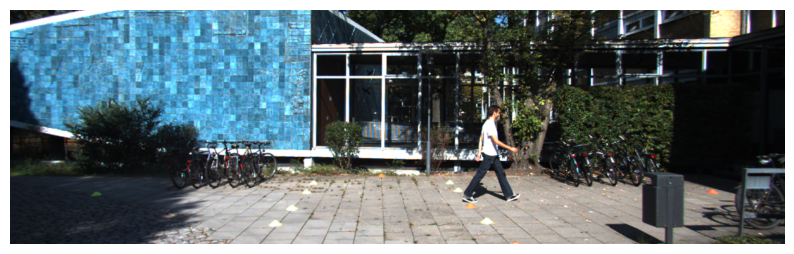

In [72]:
plt.figure(figsize=(10,20))
#plt.imshow(Image.open('/kaggle/train/000000.png'))
plt.imshow(Image.open('/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000000.png'))
plt.axis('off')
plt.show()

In [77]:
!ls -ltr /kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda

total 7160
-rw-r--r-- 1 root root   1591 Jun 14 03:20 args.yaml
-rw-r--r-- 1 root root 244729 Jun 14 03:21 labels_correlogram.jpg
-rw-r--r-- 1 root root 145482 Jun 14 03:21 labels.jpg
-rw-r--r-- 1 root root 537291 Jun 14 03:21 train_batch0.jpg
-rw-r--r-- 1 root root 497750 Jun 14 03:21 train_batch1.jpg
-rw-r--r-- 1 root root 496138 Jun 14 03:21 train_batch2.jpg
drwxr-xr-x 2 root root   4096 Jun 14 03:23 weights
-rw-r--r-- 1 root root 383869 Jun 14 10:52 train_batch122090.jpg
-rw-r--r-- 1 root root 328557 Jun 14 10:52 train_batch122091.jpg
-rw-r--r-- 1 root root 370553 Jun 14 10:52 train_batch122092.jpg
-rw-r--r-- 1 root root 385817 Jun 14 11:06 events.out.tfevents.1718335232.2379b137a266.34.0
-rw-r--r-- 1 root root 101136 Jun 14 11:06 results.csv
-rw-r--r-- 1 root root 319469 Jun 14 11:06 val_batch0_labels.jpg
-rw-r--r-- 1 root root 318283 Jun 14 11:06 val_batch0_pred.jpg
-rw-r--r-- 1 root root 308064 Jun 14 11:06 val_batch1_labels.jpg
-rw-r--r-- 1 root root 311778 Jun 14 11:06 val_bat

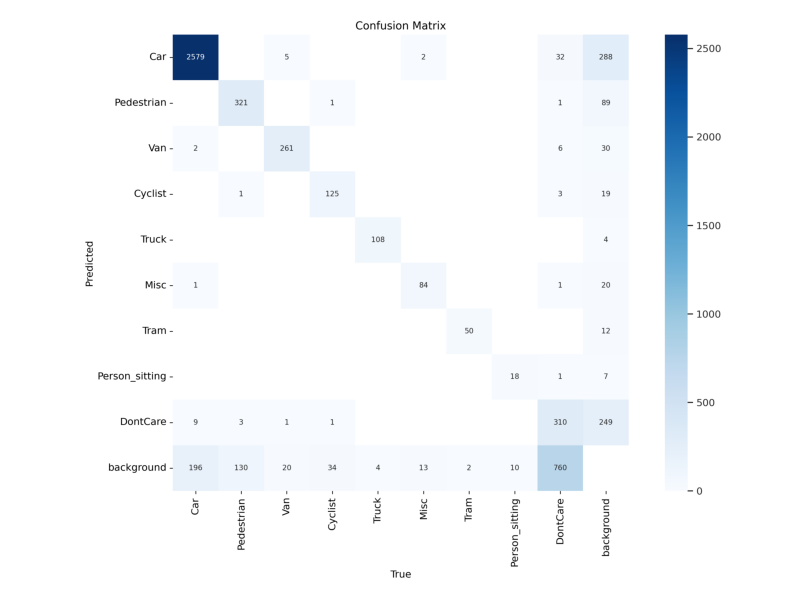

In [78]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda/confusion_matrix.png'))
plt.axis('off')
plt.show()

## **Predictions**

In [79]:
preds = model.predict([test[idx][0] for idx in np.random.randint(0,len(test),(20,))],save=True)


0: 640x640 1 Car, 1 Truck, 5.7ms
1: 640x640 1 Car, 5.7ms
2: 640x640 7 Cars, 2 Vans, 1 Cyclist, 4 Miscs, 5.7ms
3: 640x640 6 Cars, 1 Truck, 1 DontCare, 5.7ms
4: 640x640 1 Pedestrian, 1 Van, 1 Cyclist, 5.7ms
5: 640x640 7 Cars, 5.7ms
6: 640x640 1 Car, 5.7ms
7: 640x640 2 Cars, 5.7ms
8: 640x640 9 Cars, 1 Pedestrian, 2 Trucks, 5.7ms
9: 640x640 2 Cars, 1 DontCare, 5.7ms
10: 640x640 1 Car, 3 Vans, 1 Misc, 3 DontCares, 5.7ms
11: 640x640 2 Cars, 1 Truck, 1 Misc, 5.7ms
12: 640x640 4 Cars, 2 DontCares, 5.7ms
13: 640x640 2 Cars, 1 DontCare, 5.7ms
14: 640x640 6 Cars, 1 Tram, 2 DontCares, 5.7ms
15: 640x640 1 Pedestrian, 5.7ms
16: 640x640 1 Car, 1 Cyclist, 3 Trams, 5.7ms
17: 640x640 3 Cars, 1 Van, 5.7ms
18: 640x640 7 Cars, 5.7ms
19: 640x640 4 Cars, 2 Vans, 1 DontCare, 5.7ms
Speed: 2.2ms preprocess, 5.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to Yarra-yolov8n-kitti/object_june1401_training_eda2


In [81]:
!ls -ltr /kaggle/input/kitti-dataset/data_object_image_3/testing/image_3 |wc -l

7519


In [82]:
preds = list(Path('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/').glob('*'))

In [ ]:
#!ls -ltr /kaggle/input/kitti-dataset/data_object_image_3/testing/image_3

In [84]:
!ls -ltr /kaggle/working/Yarra-yolov8n-kitti/train/000523.png

ls: cannot access '/kaggle/working/Yarra-yolov8n-kitti/train/000523.png': No such file or directory


In [91]:
!ls -ltr /kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda2

total 15920
-rw-r--r-- 1 root root 758125 Jun 14 11:09 004629.png
-rw-r--r-- 1 root root 793855 Jun 14 11:09 000905.png
-rw-r--r-- 1 root root 839210 Jun 14 11:09 001843.png
-rw-r--r-- 1 root root 869061 Jun 14 11:09 006831.png
-rw-r--r-- 1 root root 855270 Jun 14 11:09 000100.png
-rw-r--r-- 1 root root 801919 Jun 14 11:09 006640.png
-rw-r--r-- 1 root root 882959 Jun 14 11:09 002411.png
-rw-r--r-- 1 root root 847933 Jun 14 11:09 007271.png
-rw-r--r-- 1 root root 890047 Jun 14 11:09 003801.png
-rw-r--r-- 1 root root 848506 Jun 14 11:09 006815.png
-rw-r--r-- 1 root root 677522 Jun 14 11:09 003013.png
-rw-r--r-- 1 root root 783610 Jun 14 11:09 004126.png
-rw-r--r-- 1 root root 812171 Jun 14 11:09 000991.png
-rw-r--r-- 1 root root 722227 Jun 14 11:09 004373.png
-rw-r--r-- 1 root root 814424 Jun 14 11:09 007051.png
-rw-r--r-- 1 root root 884058 Jun 14 11:09 002799.png
-rw-r--r-- 1 root root 763121 Jun 14 11:09 001880.png
-rw-r--r-- 1 root root 901311 Jun 14 11:09 004688.png
-rw-r--r-- 1 roo

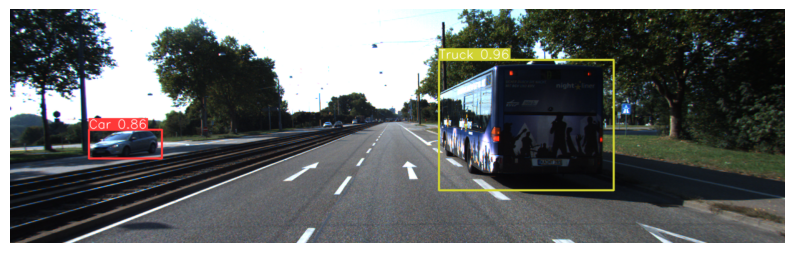

In [92]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda2/004629.png'))
plt.axis('off')
plt.show()

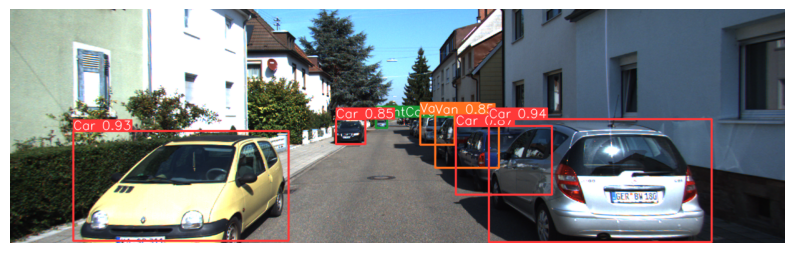

In [93]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda2/005822.png'))
plt.axis('off')
plt.show()

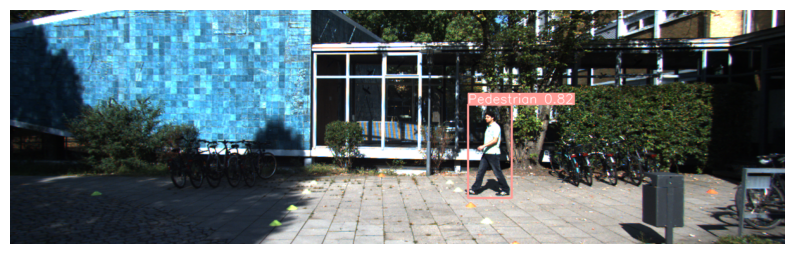

In [94]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda2/002799.png'))
plt.axis('off')
plt.show()

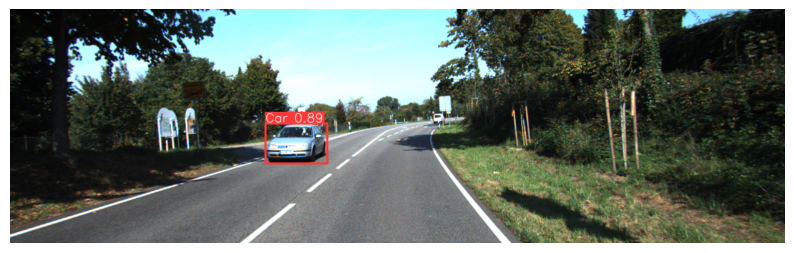

In [95]:
plt.figure(figsize=(10,20))
plt.imshow(Image.open('/kaggle/working/Yarra-yolov8n-kitti/object_june1401_training_eda2/002411.png'))
plt.axis('off')
plt.show()

In [96]:
print(preds)

[PosixPath('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/005084.png'), PosixPath('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/003065.png'), PosixPath('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/003741.png'), PosixPath('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/004725.png'), PosixPath('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/001183.png'), PosixPath('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/005660.png'), PosixPath('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/007355.png'), PosixPath('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/003244.png'), PosixPath('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/002594.png'), PosixPath('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/001703.png'), PosixPath('/kaggle/input/kitti-dataset/data_object_image_3/testing/image_3/003380.png'), PosixPath('/kaggle/i

In [97]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))


In [ ]:
#download_file('/kaggle/working/Yarra-yolov8n-kitti', 'out')
download_file('/kaggle/working', 'Yarra_June14')

